In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
# Loading Datasets on to DataFrames
indicators_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/2018_all_indicators.csv'
education_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/adult_education_level.csv'

inds_df = pd.read_csv(indicators_url)
ed_df = pd.read_csv(education_url)

# Column 9999 in the Indicators Dataset only shows the latest value from the data drawn within 1990 to 2017.
# In order to detect education system growth predictors this column is unneccessary.
inds_df = inds_df.drop(columns=['9999'])

In [4]:
# Many indicators from 1990 to 2017 that only have at most one or two recordings for a specific indicators.
# These recordings may or may not indicate growth over the years which will not contribute to our analysis.
# These indicators will be dropped.
# When threshold = 1, it removed 25636 - 20588 = 5048 / 25636 = 20% of the indicators
threshold = 20
drop_stack = set()
print(len(inds_df))
for index, row in inds_df.iterrows():
#     print(row['1990':].count())
    if row['1990':].count() <= threshold:
        drop_stack.add(index)
inds_df = inds_df.drop(drop_stack)
print(len(inds_df))


25636
6242


In [5]:
# Get the missing values at each year and return the array of years (aka. column)
def get_missing_yearly_values(row):
    row_df = row.to_frame().reset_index()
    row_df = row_df.drop(range(5))
    row_df.columns = ['x', 'y']
    missing_X = row_df[row_df['y'].isnull()].x
    return missing_X

# Predicting the missing values using Linear Regression Models
# and then filling out the missing values based on the model
year_columns = inds_df.columns.values[5:]
for index, row in inds_df.iterrows():
    missing_years = get_missing_yearly_values(row).values
    # If there are nothing to fill out then we don't need to model it out.
    if missing_years.size <= 0:
        continue
    row = row.drop(missing_years)
    row = row.drop(['dimension', 'indicator_id', 'indicator_name', 'iso3', 'country_name'])
    value = row.values.reshape(-1, 1)
    year = year_columns
    # The difference set of total years and missing years are the years where there are recorded values.
    year = np.setdiff1d(year, missing_years).astype(int).reshape(-1, 1)
    missing_years = missing_years.astype(int)
    missing_years = missing_years.reshape(missing_years.shape[0],-1)
    
    reg = LinearRegression()
    reg.fit(year, value)
    missing_values = reg.predict(missing_years)
    # Filling out the missing data
    for i in range(len(missing_years)):
        inds_df.at[index, str(missing_years[i][0])] = missing_values[i][0]
        

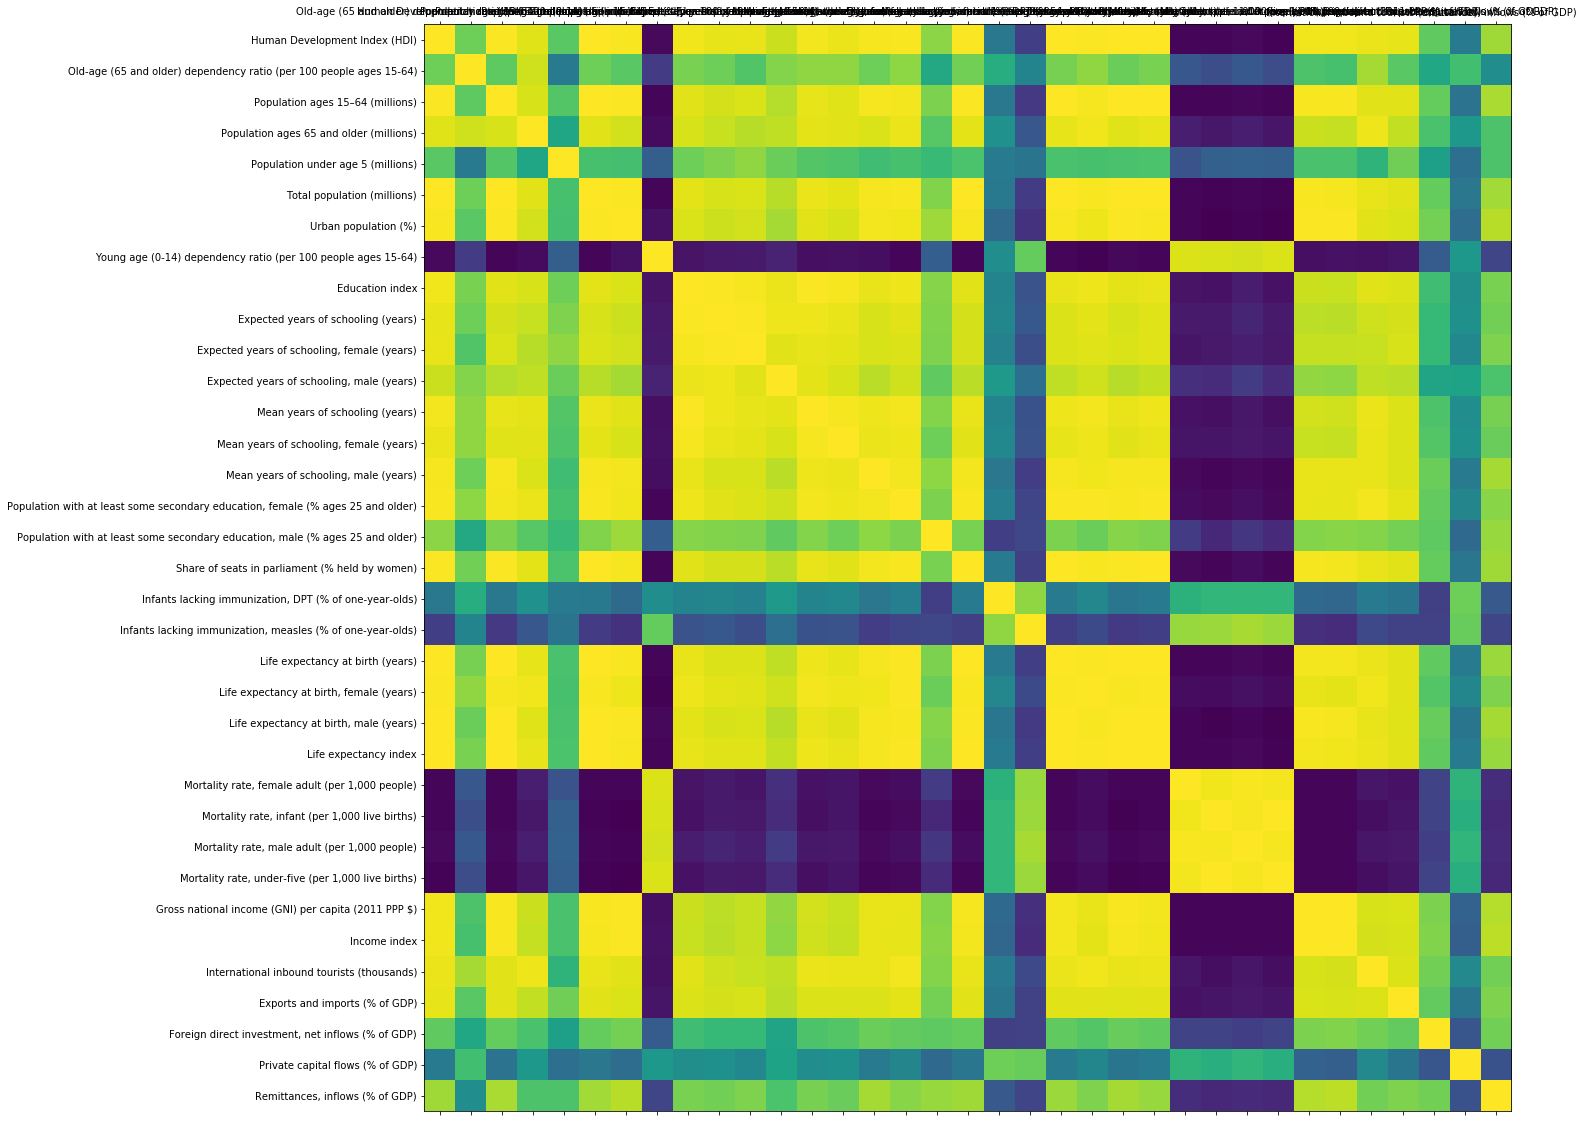

In [6]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
country_names = inds_df.country_name.unique()
  
def plot_corr_country(df, country):
  # drop ids etc., get only rows with country, transpose
  df_corr = inds_df.drop(df.columns[[0, 1, 3]], axis=1)[df.country_name == country].T
  # fix columns
  df_corr.columns = df_corr.iloc[0]
  # drop first two rops
  df_corr = df_corr[2:]
  # df_corr = inds_df.drop(inds_df.columns[[0, 1, 3]], axis=1).drop(inds_df.columns[range(5,32)], axis=1)[inds_df.country_name == "Albania"]
  df_corr = df_corr.apply(pd.to_numeric)
  plot_corr(df_corr, size=20)
  return df_corr

# change threshold to get more columns 
df_corr = plot_corr_country(inds_df, "United States")

In [60]:
def strongest_indicators(df_corr, num_indicators):
    possible_strongest = []
    for row in df_corr.corr():
        #corr_dict.update(row = df_corr.corr()[row])
        possible_strongest.append([row, df_corr.corr()[row]['Education index']])
        possible_strongest.sort(key = 
                                    lambda corr: corr[1])
    #gets rid of the correlation with the same feature
    possible_strongest = possible_strongest[:-1]
    return possible_strongest[len(possible_strongest)-num_indicators:len(possible_strongest)]

potential_indicators = strongest_indicators(df_corr, 10)

def check_corr(df_corr, potential_indicators, target_feature):
    features_ex = [indicator[0] for indicator in potential_indicators]
    features_ex.remove(target_feature)
    for feature in features_ex:
        if df_corr.corr()[target_feature][feature] > 0.95:
            return False
    return True

potential_ret_val = []
for indicator_pair in potential_indicators:
    potential_ret_val.append(check_corr(df_corr, potential_indicators, indicator_pair[0]))
print(potential_ret_val)

#def check_independence(potential_indicators):
    
    
        

In [12]:
df_corr.corr()

indicator_name                                      Human Development Index (HDI)  \
indicator_name                                                                      
Human Development Index (HDI)                                            1.000000   
Old-age (65 and older) dependency ratio (per 10...                       0.561934   
Population ages 15–64 (millions)                                         0.988785   
Population ages 65 and older (millions)                                  0.905013   
Population under age 5 (millions)                                        0.491210   
Total population (millions)                                              0.992437   
Urban population (%)                                                     0.979007   
Young age (0-14) dependency ratio (per 100 peop...                      -0.948025   
Education index                                                          0.956854   
Expected years of schooling (years)                                      0.927807   
Expected years of schooling, female (years)                              0.930025   
Expected years of schooling, male (years)                                0.842888   
Mean years of schooling (years)                                          0.964931   
Mean years of schooling, female (years)                                  0.942395   
Mean years of schooling, male (years)                                    0.976217   
Population with at least some secondary educati...                       0.983587   
Population with at least some secondary educati...                       0.652758   
Share of seats in parliament (% held by women)                           0.985356   
Infants lacking immunization, DPT (% of one-yea...                      -0.195271   
Infants lacking immunization, measles (% of one...                      -0.625500   
Life expectancy at birth (years)                                         0.994064   
Life expectancy at birth, female (years)                                 0.984631   
Life expectancy at birth, male (years)                                   0.992592   
Life expectancy index                                                    0.995283   
Mortality rate, female adult (per 1,000 people)                         -0.963561   
Mortality rate, infant (per 1,000 live births)                          -0.971364   
Mortality rate, male adult (per 1,000 people)                           -0.943068   
Mortality rate, under-five (per 1,000 live births)                      -0.973892   
Gross national income (GNI) per capita (2011 PP...                       0.959559   
Income index                                                             0.955214   
International inbound tourists (thousands)                               0.937729   
Exports and imports (% of GDP)                                           0.926766   
Foreign direct investment, net inflows (% of GDP)                        0.515629   
Private capital flows (% of GDP)                                        -0.180500   
Remittances, inflows (% of GDP)                                          0.712734   

indicator_name                                      Old-age (65 and older) dependency ratio (per 100 people ages 15-64)  \
indicator_name                                                                                                            
Human Development Index (HDI)                                                                0.561934                     
Old-age (65 and older) dependency ratio (per 10...                                           1.000000                     
Population ages 15–64 (millions)                                                             0.503312                     
Population ages 65 and older (millions)                                                      0.852551                     
Population under age 5 (millions)                                                           -0.172902               

In [14]:
df_corr.corr().info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, Human Development Index (HDI) to Remittances, inflows (% of GDP)
Data columns (total 35 columns):
Human Development Index (HDI)                                                      35 non-null float64
Old-age (65 and older) dependency ratio (per 100 people ages 15-64)                35 non-null float64
Population ages 15–64 (millions)                                                   35 non-null float64
Population ages 65 and older (millions)                                            35 non-null float64
Population under age 5 (millions)                                                  35 non-null float64
Total population (millions)                                                        35 non-null float64
Urban population (%)                                                               35 non-null float64
Young age (0-14) dependency ratio (per 100 people ages 15-64)                      35 non-null float64
Education index      

In [17]:
#df_corr.corr()['Old-age (65 and older) dependency ratio (per 100 people ages 15-64)']['Human Development Index (HDI)']
df_corr.corr()['Old-age (65 and older) dependency ratio (per 100 people ages 15-64)']

indicator_name
Human Development Index (HDI)                                                      0.561934
Old-age (65 and older) dependency ratio (per 100 people ages 15-64)                1.000000
Population ages 15–64 (millions)                                                   0.503312
Population ages 65 and older (millions)                                            0.852551
Population under age 5 (millions)                                                 -0.172902
Total population (millions)                                                        0.563382
Urban population (%)                                                               0.488395
Young age (0-14) dependency ratio (per 100 people ages 15-64)                     -0.648901
Education index                                                                    0.601153
Expected years of schooling (years)                                                0.555902
Expected years of schooling, female (years)                      

In [18]:
df_corr.corr().keys()

Index(['Human Development Index (HDI)',
       'Old-age (65 and older) dependency ratio (per 100 people ages 15-64)',
       'Population ages 15–64 (millions)',
       'Population ages 65 and older (millions)',
       'Population under age 5 (millions)', 'Total population (millions)',
       'Urban population (%)',
       'Young age (0-14) dependency ratio (per 100 people ages 15-64)',
       'Education index', 'Expected years of schooling (years)',
       'Expected years of schooling, female (years)',
       'Expected years of schooling, male (years)',
       'Mean years of schooling (years)',
       'Mean years of schooling, female (years)',
       'Mean years of schooling, male (years)',
       'Population with at least some secondary education, female (% ages 25 and older)',
       'Population with at least some secondary education, male (% ages 25 and older)',
       'Share of seats in parliament (% held by women)',
       'Infants lacking immunization, DPT (% of one-year-olds)',


In [20]:
len(df_corr.corr())

35

In [57]:
#list containing sublist first value is key second is 
corr_x = []
for row in df_corr.corr():
    #corr_dict.update(row = df_corr.corr()[row])
    corr_x.append([row, df_corr.corr()[row]['Education index']])
corr_x.sort(key = 
             lambda corr: corr[1])
#gets rid of the correlation with the same feature
corr_x = corr_x[:-1]

print(corr_x)

[['Mortality rate, under-five (per 1,000 live births)', -0.8957301801890567], ['Mortality rate, infant (per 1,000 live births)', -0.8939259309172504], ['Young age (0-14) dependency ratio (per 100 people ages 15-64)', -0.8899332554336324], ['Mortality rate, female adult (per 1,000 people)', -0.8861986066255351], ['Mortality rate, male adult (per 1,000 people)', -0.8429782691031374], ['Infants lacking immunization, measles (% of one-year-olds)', -0.48092306585261724], ['Infants lacking immunization, DPT (% of one-year-olds)', -0.09184661807705537], ['Private capital flows (% of GDP)', -0.008418543365733009], ['Foreign direct investment, net inflows (% of GDP)', 0.38921651219583736], ['Population under age 5 (millions)', 0.5574842754950077], ['Remittances, inflows (% of GDP)', 0.5962059359960289], ['Old-age (65 and older) dependency ratio (per 100 people ages 15-64)', 0.6011532700567224], ['Population with at least some secondary education, male (% ages 25 and older)', 0.6400665480528305]

Human Development Index (HDI)
Old-age (65 and older) dependency ratio (per 100 people ages 15-64)
Population ages 15–64 (millions)
Population ages 65 and older (millions)
Population under age 5 (millions)
Total population (millions)
Urban population (%)
Young age (0-14) dependency ratio (per 100 people ages 15-64)
Education index
Expected years of schooling (years)
Expected years of schooling, female (years)
Expected years of schooling, male (years)
Mean years of schooling (years)
Mean years of schooling, female (years)
Mean years of schooling, male (years)
Population with at least some secondary education, female (% ages 25 and older)
Population with at least some secondary education, male (% ages 25 and older)
Share of seats in parliament (% held by women)
Infants lacking immunization, DPT (% of one-year-olds)
Infants lacking immunization, measles (% of one-year-olds)
Life expectancy at birth (years)
Life expectancy at birth, female (years)
Life expectancy at birth, male (years)
Life

In [19]:
df_corr.corr()['Human Development Index (HDI)']['Education index']

0.9568539316505816

In [62]:
potential_indicators

[['Life expectancy at birth (years)', 0.9314780436034437],
 ['Life expectancy index', 0.9350690218123131],
 ['Expected years of schooling, male (years)', 0.9453969782985058],
 ['Population with at least some secondary education, female (% ages 25 and older)',
  0.9473475068134908],
 ['Life expectancy at birth, female (years)', 0.9481973326342565],
 ['Human Development Index (HDI)', 0.9568539316505816],
 ['Mean years of schooling, female (years)', 0.9696290590871636],
 ['Expected years of schooling, female (years)', 0.9718754613066345],
 ['Mean years of schooling (years)', 0.9848881294837082],
 ['Expected years of schooling (years)', 0.9870438737592965]]

In [94]:
def check_corr(df_corr, potential_indicators, target_feature):
    features_ex = [indicator[0] for indicator in potential_indicators]
    features_ex.remove(target_feature)
    for feature in features_ex:
        if df_corr.corr()[target_feature][feature] > 0.95:
            return False
    return True

potential_ret_val = []
for indicator_pair in potential_indicators:
    potential_ret_val.append(check_corr(df_corr, potential_indicators, indicator_pair[0]))
print(potential_ret_val)
#print([indicator[0] for indicator in potential_indicators])
#print([indicator[0] for indicator in potential_indicators].remove('Expected years of schooling (years)'))
#check_corr(df_corr, potential_indicators, 'Expected years of schooling (years)')
#for indicator_pair in potential_indicators:
    

[False, False, False, False, False, False, False, False, False, False]


Health Effects

       indicator_name                        country_name      1990      1991  \
2063  Education index                         Afghanistan  0.122000  0.133000   
2064  Education index                             Albania  0.584000  0.589000   
2065  Education index                             Algeria  0.385000  0.395000   
2069  Education index                           Argentina  0.628000  0.632000   
2070  Education index                             Armenia  0.634000  0.637000   
2071  Education index                           Australia  0.873000  0.874000   
2072  Education index                             Austria  0.676000  0.683000   
2073  Education index                          Azerbaijan  0.592814  0.597334   
2075  Education index                             Bahrain  0.574000  0.586000   
2076  Education index                          Bangladesh  0.251000  0.260000   
2077  Education index                            Barbados  0.625000  0.632000   
2078  Education index       

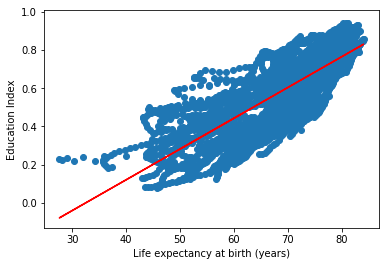

In [69]:
def plot_health(df):
    health_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    life_expectancy = health_df[health_df.indicator_name == "Life expectancy at birth (years)"]
    education_index = health_df[health_df.indicator_name == "Education index"]
    life_ex = []
    education_i = []
    for i in range(len(life_expectancy)):
        for j in range(1990, 2018):
            c_val = life_expectancy["country_name"].iloc[i]
            if c_val in list(education_index["country_name"]):
                life_ex.append(life_expectancy[str(j)].iloc[i])
                education_i.append(education_index[education_index.country_name == c_val][str(j)].iloc[0])
    plt.xlabel("Life expectancy at birth (years)")
    plt.ylabel("Education Index")
    plt.scatter(life_ex, education_i)
    fit = np.polyfit(life_ex, education_i, 1)
    fit_fn = np.poly1d(fit)
    plt.plot(life_ex, fit_fn(life_ex), color="red")
plot_health(inds_df)


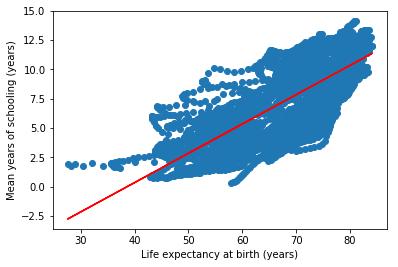

In [205]:
def plot_mean_schooling(df):
    mean_school_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    life_expectancy = mean_school_df[mean_school_df.indicator_name == "Life expectancy at birth (years)"]
    mean_years = mean_school_df[mean_school_df.indicator_name == "Mean years of schooling (years)"]
    life_ex = []
    mean_years_i = []
    for i in range(len(life_expectancy)):
        for j in range(1990, 2018):
            c_val = life_expectancy["country_name"].iloc[i]
            if c_val in list(mean_years["country_name"]):
                life_ex.append(life_expectancy[str(j)].iloc[i])
                mean_years_i.append(mean_years[mean_years.country_name == c_val][str(j)].iloc[0])
    plt.xlabel("Life expectancy at birth (years)")
    plt.ylabel("Mean years of schooling (years)")
    plt.scatter(life_ex, mean_years_i)
    fit = np.polyfit(life_ex, mean_years_i, 1)
    fit_fn = np.poly1d(fit)
    plt.plot(life_ex, fit_fn(life_ex), color="red")
plot_mean_schooling(inds_df)

In [6]:
full_inds_df = pd.read_csv(indicators_url)

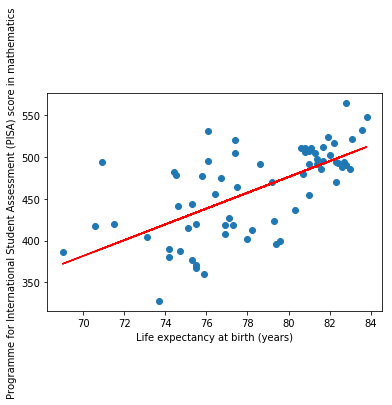

In [197]:
def plot_pisa_math(df):
    #Retrieves the rows where the indicator is equal to the respective values
    life_expectancy = df[df.indicator_name == "Life expectancy at birth (years)"]
    pisa = df[df.indicator_name == "Programme for International Student Assessment (PISA) score in mathematics"]
    life_val = []
    pisa_val = []
    for i in range(len(life_expectancy)):
        c_val = life_expectancy["country_name"].iloc[i]
        #checks to see if both life_expectancy and pisa have this country entry 
        if c_val in list(pisa["country_name"]):
            life_val.append(life_expectancy["2015"].iloc[i])
            #picks out the pisa entry for that country for 2015
            pisa_val.append(pisa[pisa.country_name == c_val]["2015"].iloc[0])
    plt.xlabel("Life expectancy at birth (years)")
    plt.ylabel("Programme for International Student Assessment (PISA) score in mathematics")
    plt.scatter(life_val, pisa_val)
    fit = np.polyfit(life_val, pisa_val, 1)
    fit_fn = np.poly1d(fit)
    plt.plot(life_val, fit_fn(life_val), color="red")

plot_pisa_math(full_inds_df)

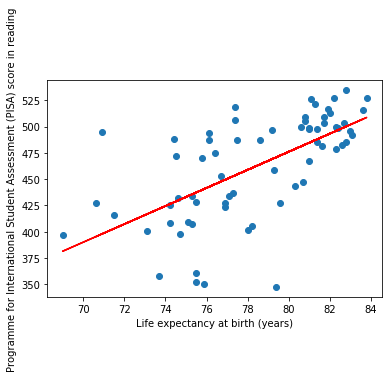

In [198]:
def plot_pisa_reading(df):
    #Retrieves the rows where the indicator is equal to the respective values
    life_expectancy = df[df.indicator_name == "Life expectancy at birth (years)"]
    pisa = df[df.indicator_name == "Programme for International Student Assessment (PISA) score in reading"]
    life_val = []
    pisa_val = []
    for i in range(len(life_expectancy)):
        c_val = life_expectancy["country_name"].iloc[i]
        #checks to see if both life_expectancy and pisa have this country entry 
        if c_val in list(pisa["country_name"]):
            life_val.append(life_expectancy["2015"].iloc[i])
            #picks out the pisa entry for that country for 2015
            pisa_val.append(pisa[pisa.country_name == c_val]["2015"].iloc[0])
    plt.xlabel("Life expectancy at birth (years)")
    plt.ylabel("Programme for International Student Assessment (PISA) score in reading")
    plt.scatter(life_val, pisa_val)
    fit = np.polyfit(life_val, pisa_val, 1)
    fit_fn = np.poly1d(fit)
    plt.plot(life_val, fit_fn(life_val), color="red")
    
plot_pisa_reading(full_inds_df)

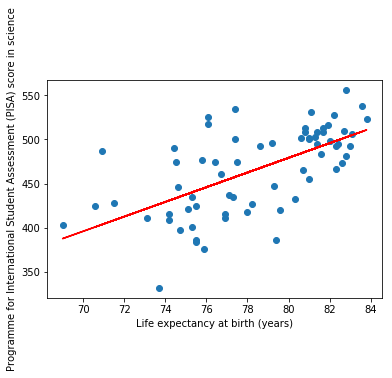

In [199]:
def plot_pisa_science(df):
    #Retrieves the rows where the indicator is equal to the respective values
    life_expectancy = df[df.indicator_name == "Life expectancy at birth (years)"]
    pisa = df[df.indicator_name == "Programme for International Student Assessment (PISA) score in science"]
    life_val = []
    pisa_val = []
    for i in range(len(life_expectancy)):
        c_val = life_expectancy["country_name"].iloc[i]
        #checks to see if both life_expectancy and pisa have this country entry 
        if c_val in list(pisa["country_name"]):
            life_val.append(life_expectancy["2015"].iloc[i])
            #picks out the pisa entry for that country for 2015
            pisa_val.append(pisa[pisa.country_name == c_val]["2015"].iloc[0])
    plt.xlabel("Life expectancy at birth (years)")
    plt.ylabel("Programme for International Student Assessment (PISA) score in science")
    plt.scatter(life_val, pisa_val)
    fit = np.polyfit(life_val, pisa_val, 1)
    fit_fn = np.poly1d(fit)
    plt.plot(life_val, fit_fn(life_val), color="red")

plot_pisa_science(full_inds_df)

In [158]:
full_inds_df[full_inds_df.indicator_name == "Programme for International Student Assessment (PISA) score in mathematics"]

dimension  indicator_id  \
5232  Education        177006   
5233  Education        177006   
5234  Education        177006   
5235  Education        177006   
5236  Education        177006   
5237  Education        177006   
5238  Education        177006   
5239  Education        177006   
5240  Education        177006   
5241  Education        177006   
5242  Education        177006   
5243  Education        177006   
5244  Education        177006   
5245  Education        177006   
5246  Education        177006   
5247  Education        177006   
5248  Education        177006   
5249  Education        177006   
5250  Education        177006   
5251  Education        177006   
5252  Education        177006   
5253  Education        177006   
5254  Education        177006   
5255  Education        177006   
5256  Education        177006   
5257  Education        177006   
5258  Education        177006   
5259  Education        177006   
5260  Education        177006   
5261  Education        177006   
...         ...           ...   
5269  Education        177006   
5270  Education        177006   
5271  Education        177006   
5272  Education        177006   
5273  Education        177006   
5274  Education        177006   
5275  Education        177006   
5276  Education        177006   
5277  Education        177006   
5278  Education        177006   
5279  Education        177006   
5280  Education        177006   
5281  Education        177006   
5282  Education        177006   
5283  Education        177006   
5284  Education        177006   
5285  Education        177006   
5286  Education        177006   
5287  Education        177006   
5288  Education        177006   
5289  Education        177006   
5290  Education        177006   
5291  Education        177006   
5292  Education        177006   
5293  Education        177006   
5294  Education        177006   
5295  Education        177006   
5296  Education        177006   
5297  Education        177006   
5298  Education        177006   

                                         indicator_name iso3  \
5232  Programme for International Student Assessment...  ALB   
5233  Programme for International Student Assessment...  DZA   
5234  Programme for International Student Assessment...  ARG   
5235  Programme for International Student Assessment...  AUS   
5236  Programme for International Student Assessment...  AUT   
5237  Programme for International Student Assessment...  BEL   
5238  Programme for International Student Assessment...  BRA   
5239  Programme for International Student Assessment...  BGR   
5240  Programme for International Student Assessment...  CAN   
5241  Programme for International Student Assessment...  CHL   
5242  Programme for International Student Assessment...  CHN   
5243  Programme for International Student Assessment...  COL   
5244  Programme for International Student Assessment...  CRI   
5245  Programme for International Student Assessment...  HRV   
5246  Programme for International Student Assessment...  CYP   
5247  Programme for International Student Assessment...  CZE   
5248  Programme for International Student Assessment...  DNK   
5249  Programme for International Student Assessment...  DOM   
5250  Programme for International Student Assessment...  EST   
5251  Programme for International Student Assessment...  FIN   
5252  Programme for International Student Assessment...  FRA   
5253  Programme for International Student Assessment...  GEO   
5254  Programme for International Student Assessment...  DEU   
5255  Programme for International Student Assessment...  GRC   
5256  Programme for International Student Assessment...  HKG   
5257  Programme for International Student Assessment...  HUN   
5258  Programme for International Student Assessment...  ISL   
5259  Programme for International Student Assessment...  IDN   
5260  Programme for International Student Assessment...  IRL   
5261  Programme for International Stude

In [23]:
def plot_indicators_vs_year(df, country):
    new_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    new_df = new_df[new_df.country_name == country]
    #Generating different colors
    number = len(new_df)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, number)]
    color_index = 0
    while len(new_df) > 0:
        temp = new_df.iloc[0]
        print(temp["indicator_name"])
        x_vals = []
        y_vals = []
        for year in range(1990, 2017):
            if str(temp[str(year)]) != "nan":
                x_vals.append(year)
                y_vals.append(temp[str(year)])
        plt.xlabel("Years")
        plt.ylabel("Indicator Values")
        plt.scatter(x_vals, y_vals, color = colors[color_index], alpha = .7)
        new_df = new_df.iloc[1:,]
        if len(x_vals) > 0:
            fit = np.polyfit(x_vals, y_vals, 1)
            fit_fn = np.poly1d(fit)
            plt.plot(x_vals, fit_fn(x_vals), color=colors[color_index])
        color_index += 1
        
    

In [17]:
import time

In [40]:
def plot_education_index(df):
    new_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    new_df = new_df[new_df.indicator_name == "Education index"]
    countries = []
    for i in range(0, len(new_df)):
        countries.append(new_df["country_name"].iloc[i])
    y_pos = np.arange(len(countries))
    year_education_inds = []
    for year in range(1990, 2018):
        education_ind = []
        for i in range(0, len(new_df)):
            if str(new_df[str(year)].iloc[i]) == "nan":
                education_ind.append(0)
            else:
                education_ind.append(float(new_df[str(year)].iloc[i]))
        year_education_inds.append(education_ind)
        plt.figure(figsize=(10,100))
        plt.barh(y_pos, education_ind, align='center', alpha=0.5)
        plt.yticks(y_pos, countries)
        plt.xlabel('Education index')
        #plt.pause(5)

Text(0.5, 0, 'Usage')

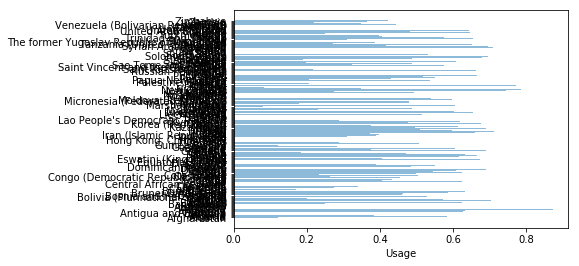

In [10]:
#objects = ['Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp']
objects = ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Congo (Democratic Republic of the)', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini (Kingdom of)', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong, China (SAR)', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran (Islamic Republic of)', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Korea (Republic of)', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Micronesia (Federated States of)', 'Moldova (Republic of)', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Palestine, State of', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Samoa', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Slovakia', 'Slovenia', 'Solomon Islands', 'South Africa', 'South Sudan', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Sweden', 'Switzerland', 'Syrian Arab Republic', 'Tajikistan', 'Tanzania (United Republic of)', 'Thailand', 'The former Yugoslav Republic of Macedonia', 'Timor-Leste', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Yemen', 'Zambia', 'Zimbabwe']
#performance = [10.0, 8.5, 6, 4, 2, 1.5]
performance = [0.122, 0.584, 0.385, 0, 0, 0, 0.628, 0.634, 0.873, 0.6759999999999999, 0, 0, 0.574, 0.251, 0.625, 0, 0.705, 0.573, 0.201, 0, 0.528, 0, 0.461, 0.46299999999999997, 0.588, 0.632, 0, 0.171, 0, 0.276, 0.33899999999999997, 0.8059999999999999, 0.214, 0, 0.626, 0.405, 0.433, 0, 0.455, 0.263, 0.505, 0.233, 0.498, 0.624, 0.546, 0.609, 0.69, 0, 0, 0.485, 0.551, 0.389, 0.382, 0, 0, 0.675, 0.40700000000000003, 0, 0.616, 0.6659999999999999, 0.632, 0.473, 0.183, 0, 0.6920000000000001, 0.375, 0.607, 0, 0.284, 0.121, 0, 0.507, 0.28800000000000003, 0.355, 0.64, 0.598, 0.6779999999999999, 0.311, 0.389, 0.397, 0.373, 0.6609999999999999, 0.7140000000000001, 0.599, 0.509, 0.691, 0.496, 0.613, 0.376, 0, 0.6759999999999999, 0.47600000000000003, 0.619, 0.28800000000000003, 0.604, 0, 0.415, 0, 0.516, 0, 0.655, 0.602, 0, 0.231, 0.488, 0, 0.081, 0.605, 0, 0.17800000000000002, 0.48100000000000004, 0.48, 0, 0.598, 0.539, 0, 0.254, 0.131, 0.251, 0.495, 0.276, 0.746, 0.787, 0.349, 0.08199999999999999, 0, 0.772, 0, 0.205, 0, 0, 0.5379999999999999, 0.207, 0.431, 0.551, 0.519, 0.665, 0.536, 0.507, 0.632, 0.6629999999999999, 0.218, 0, 0, 0, 0.5770000000000001, 0.32299999999999995, 0.489, 0.198, 0.61, 0, 0.19, 0.48700000000000004, 0.679, 0.696, 0, 0.532, 0, 0.591, 0.5920000000000001, 0.159, 0, 0.71, 0.695, 0.41700000000000004, 0.652, 0.273, 0.387, 0, 0, 0.31, 0.6559999999999999, 0.575, 0.406, 0.39899999999999997, 0, 0.25, 0.648, 0.484, 0.644, 0.836, 0.597, 0, 0, 0.444, 0.348, 0.21899999999999997, 0.365, 0.423]
y_pos = np.arange(len(objects))
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Usage')

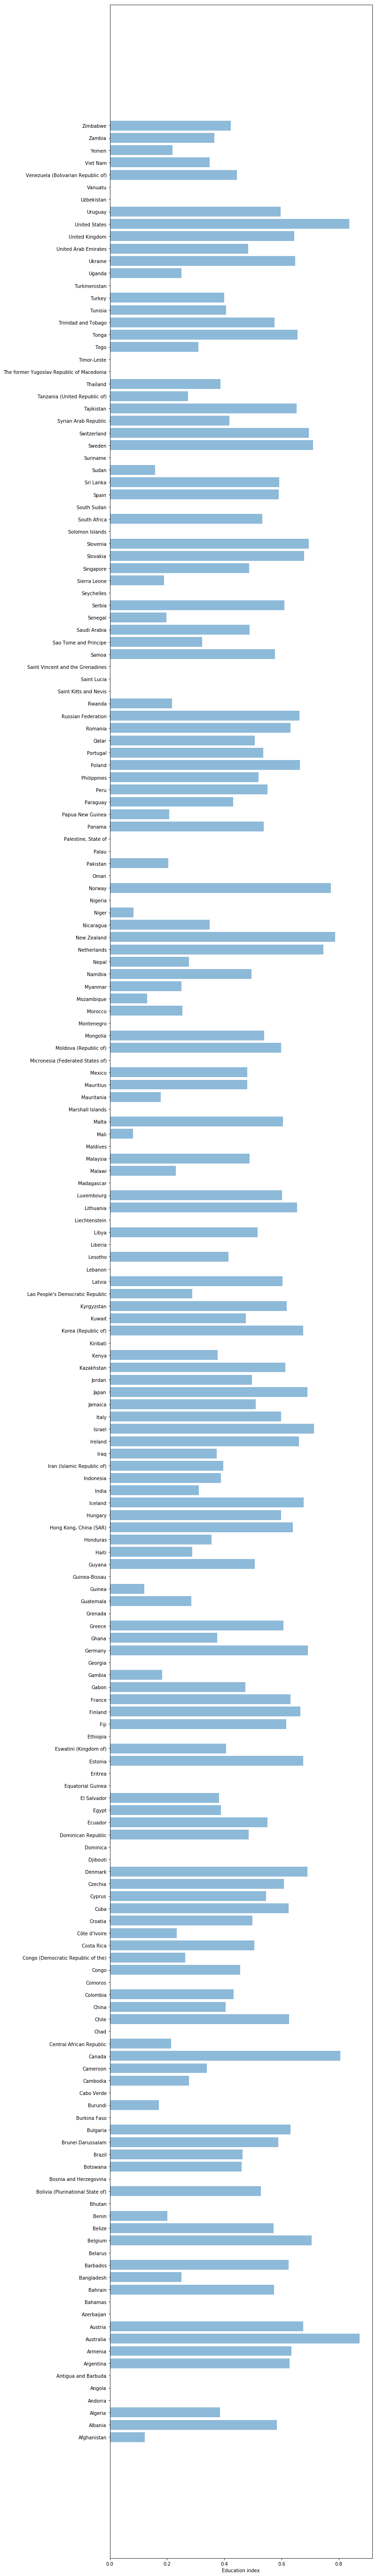

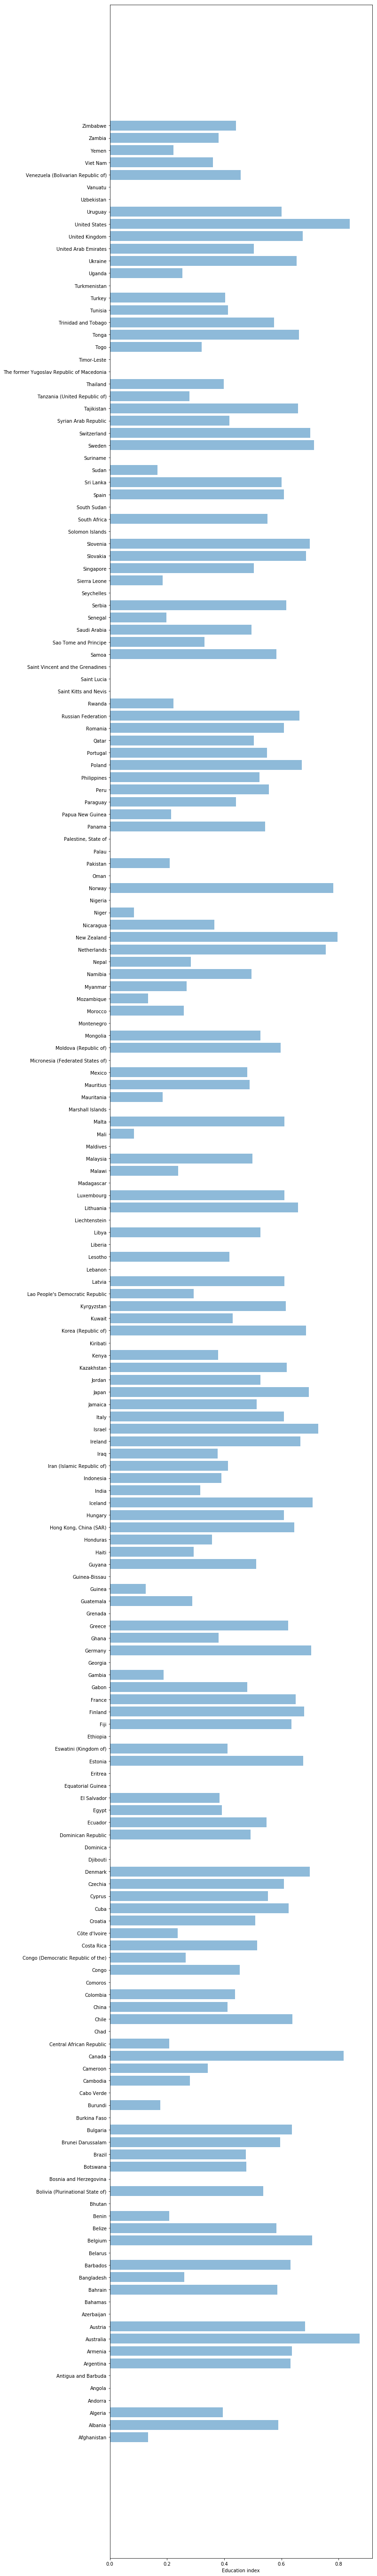

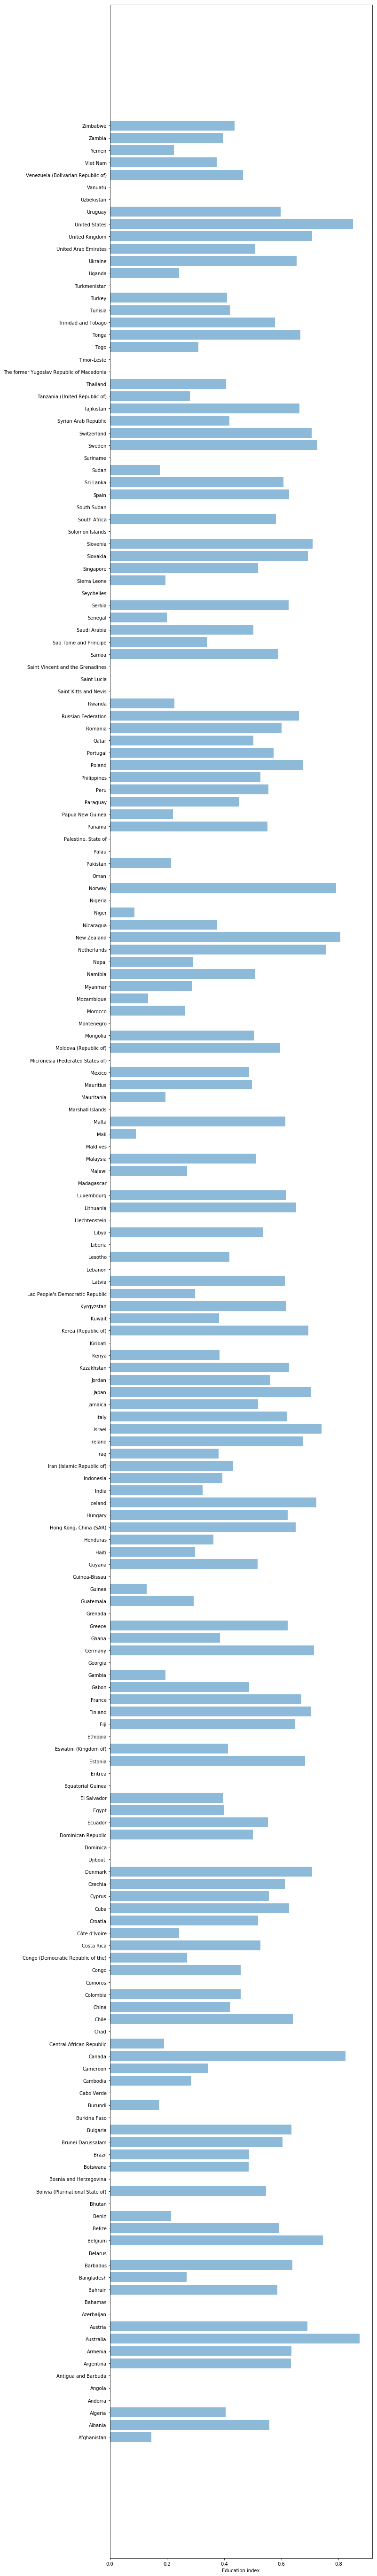

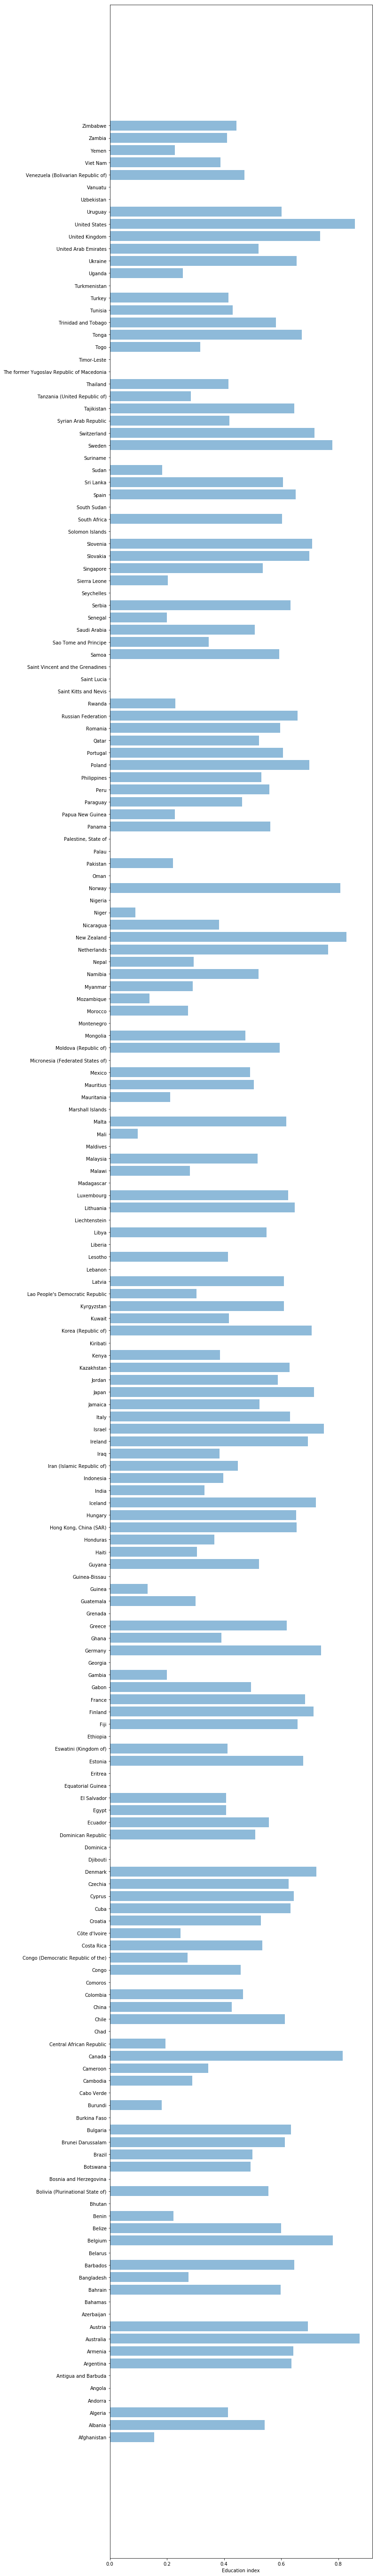

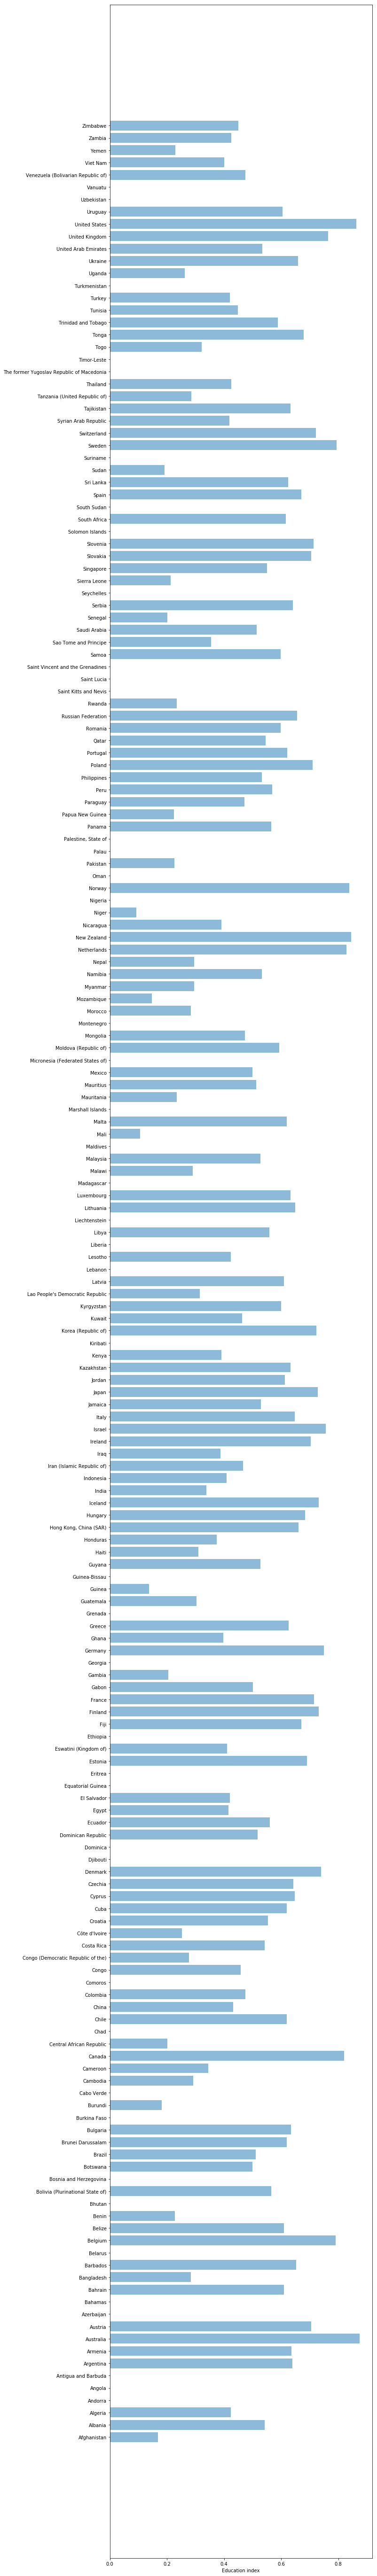

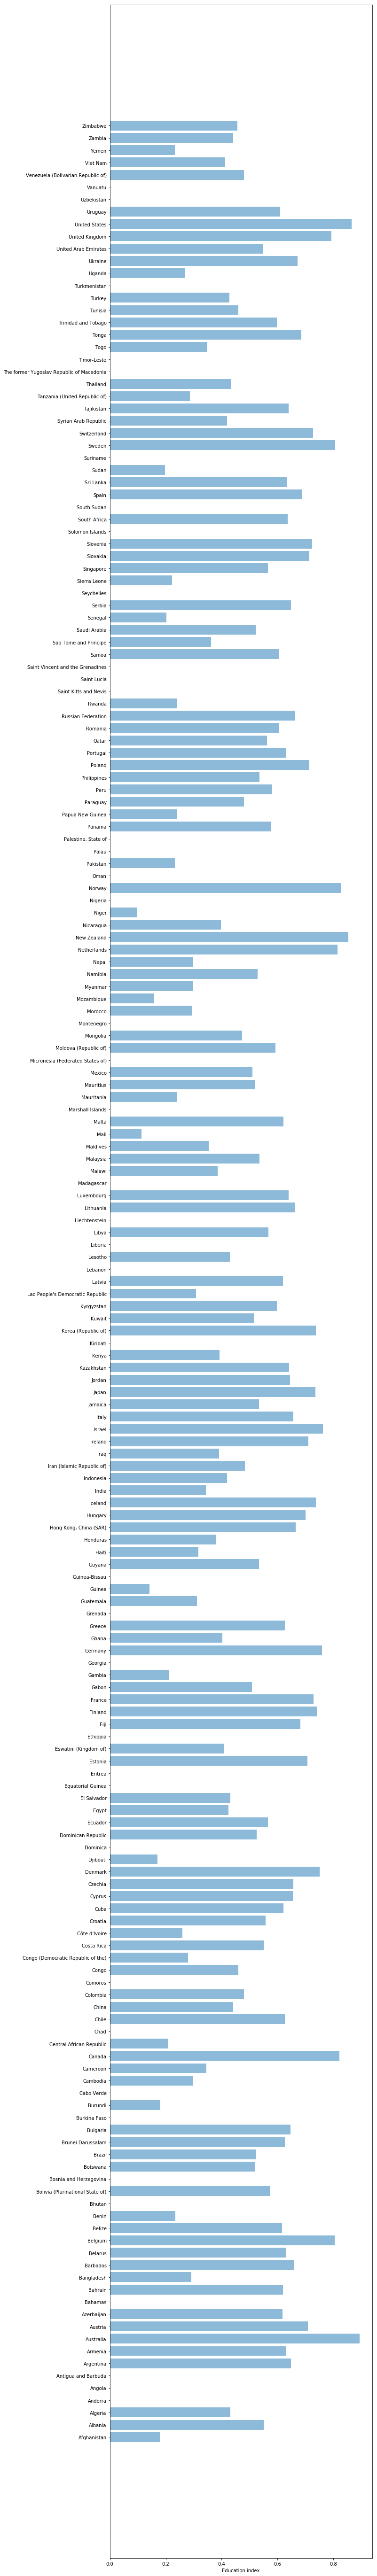

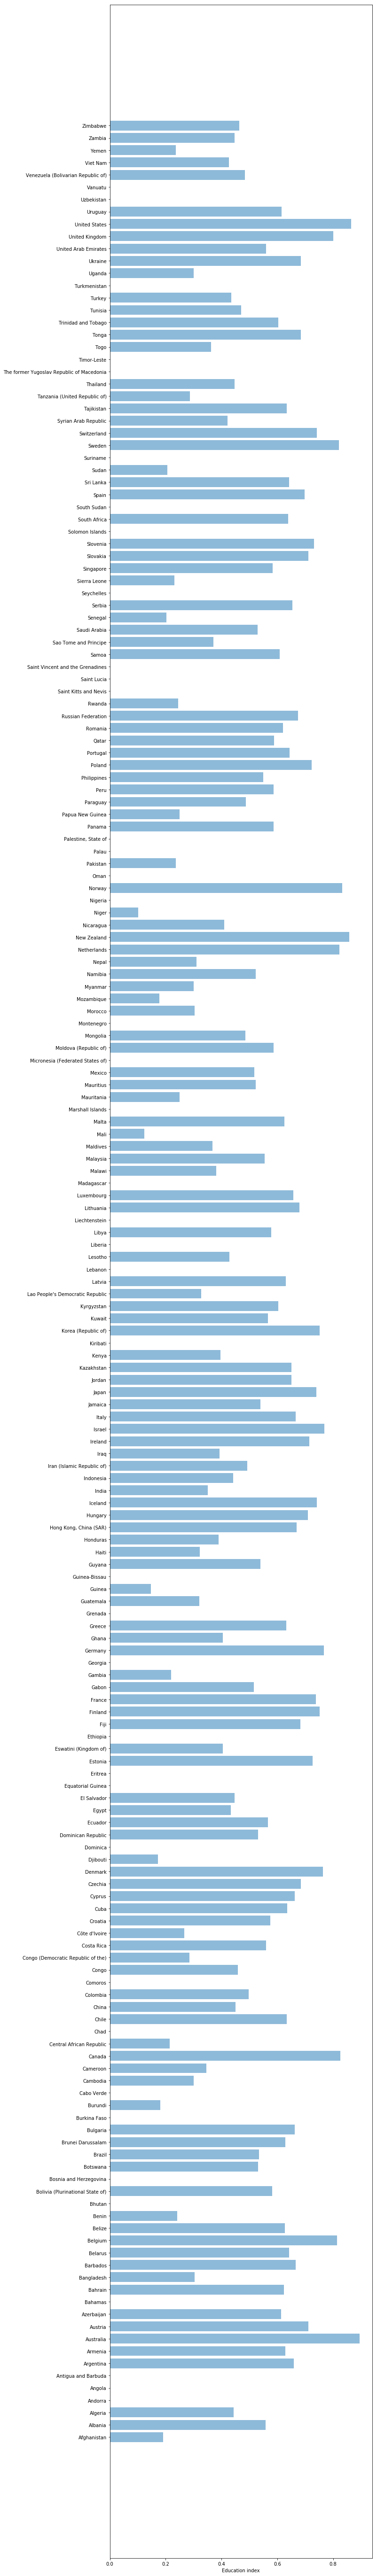

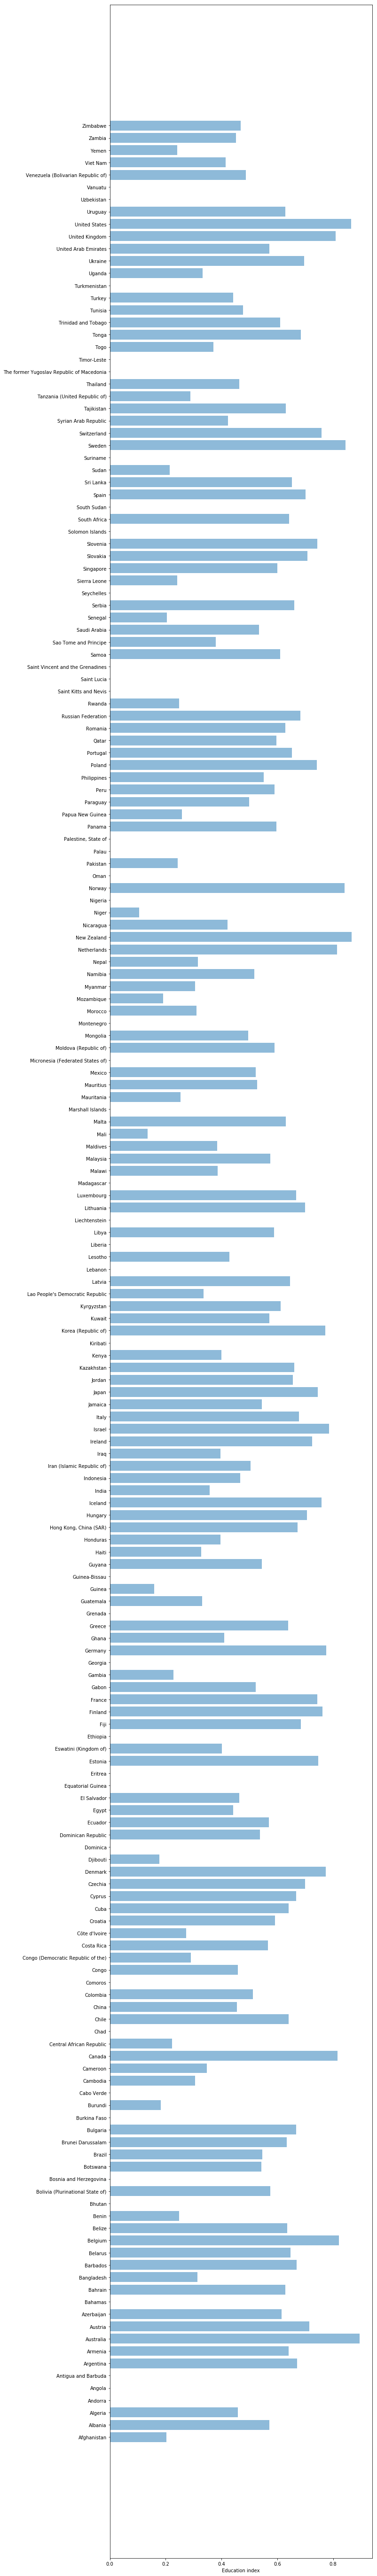

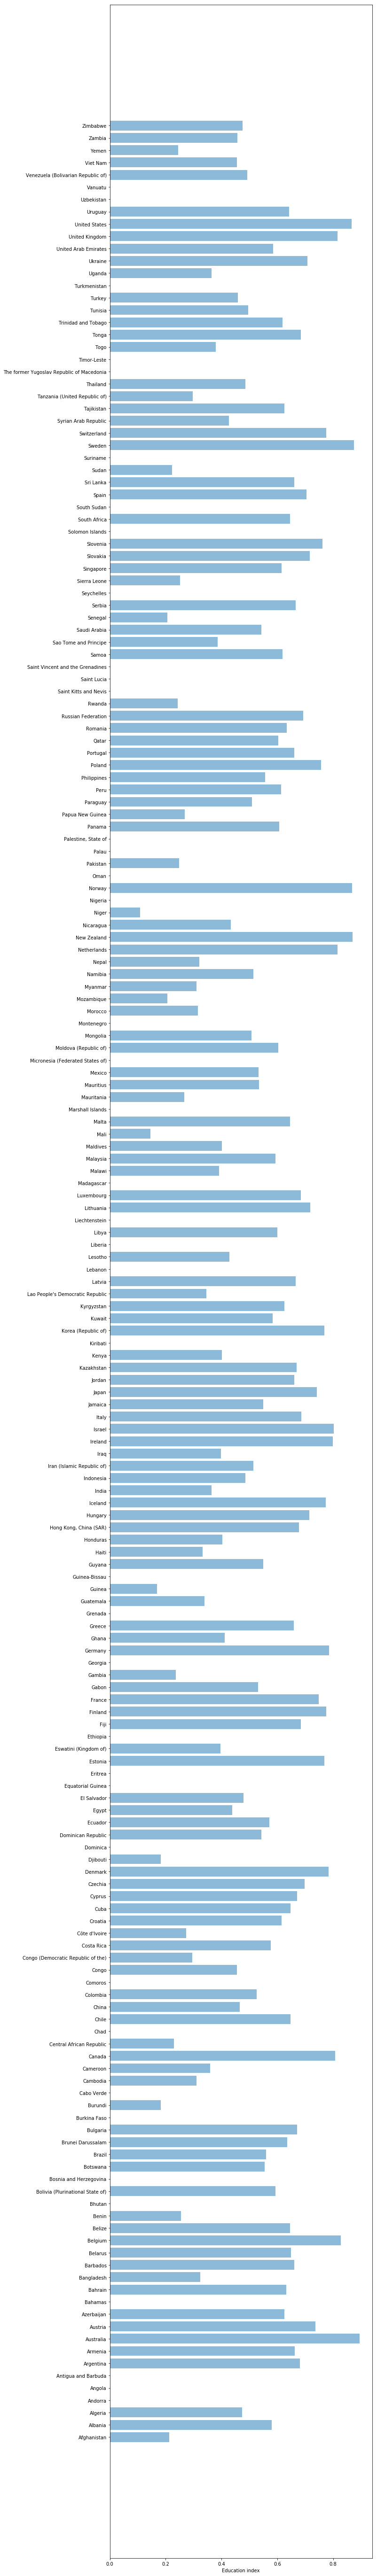

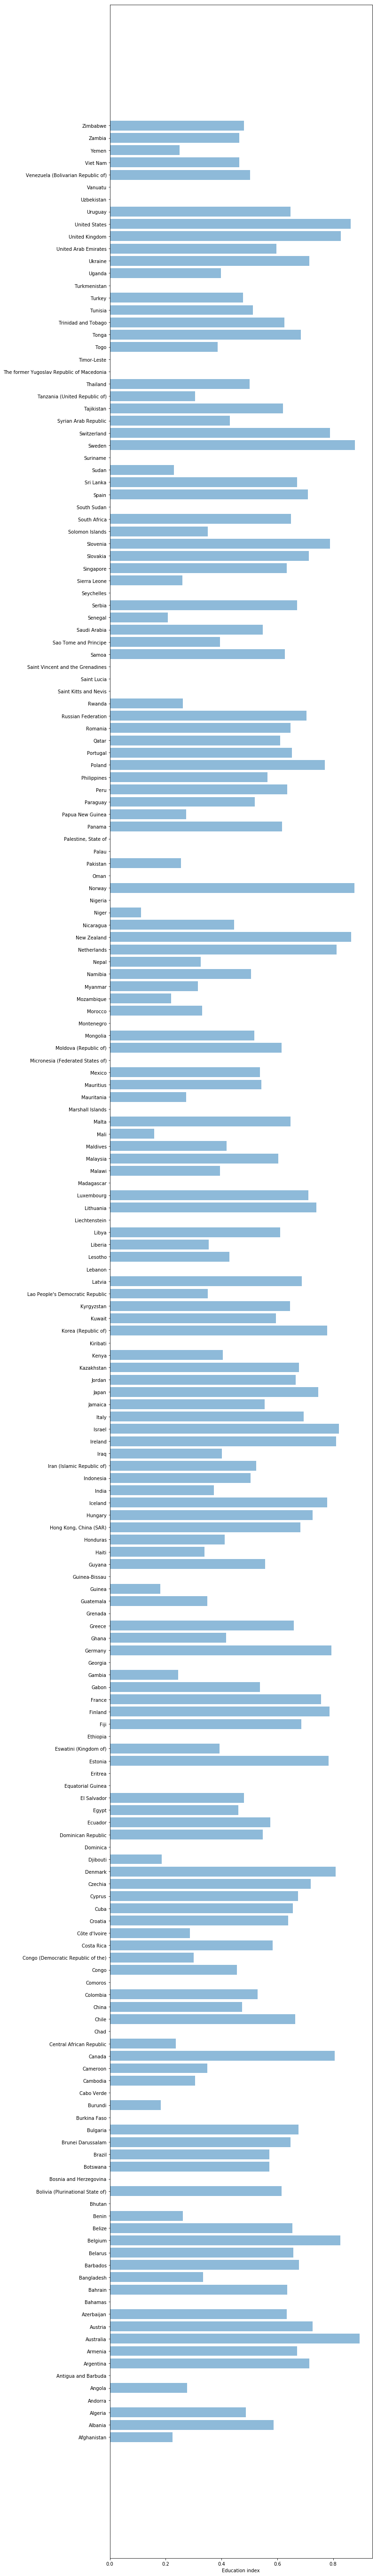

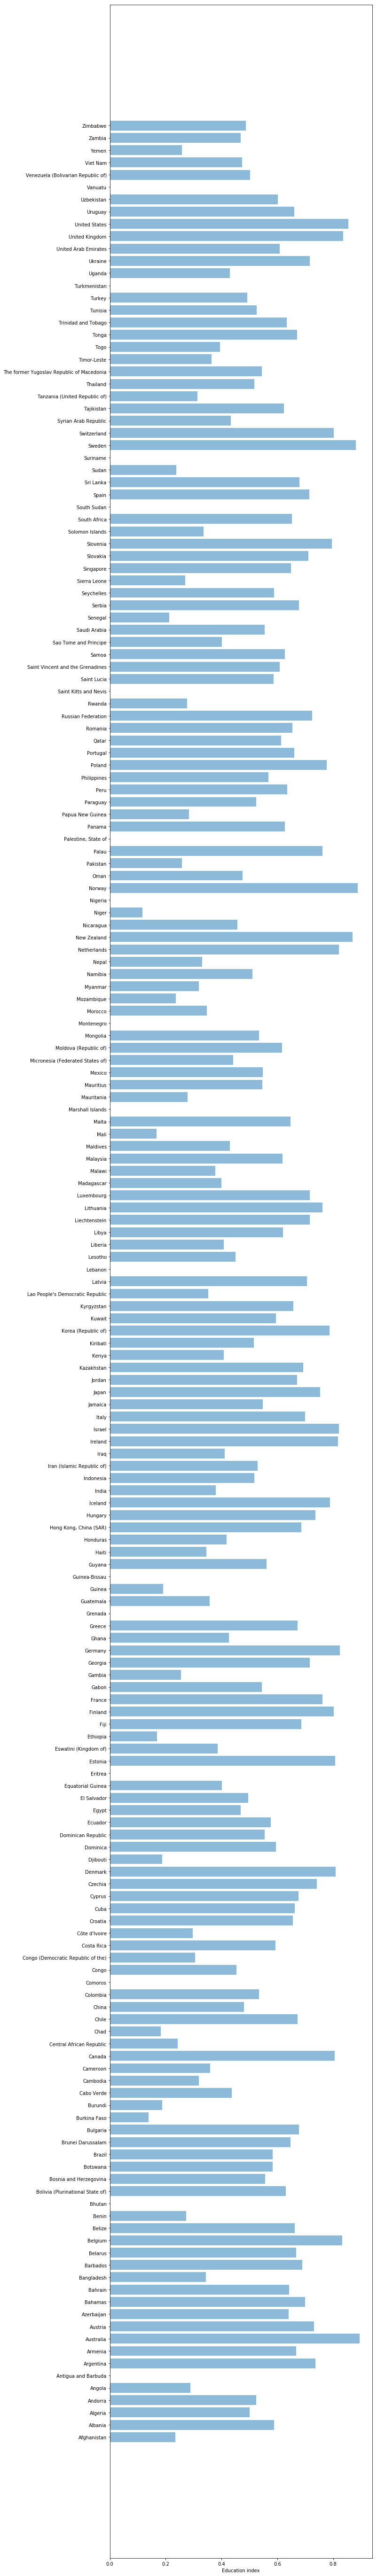

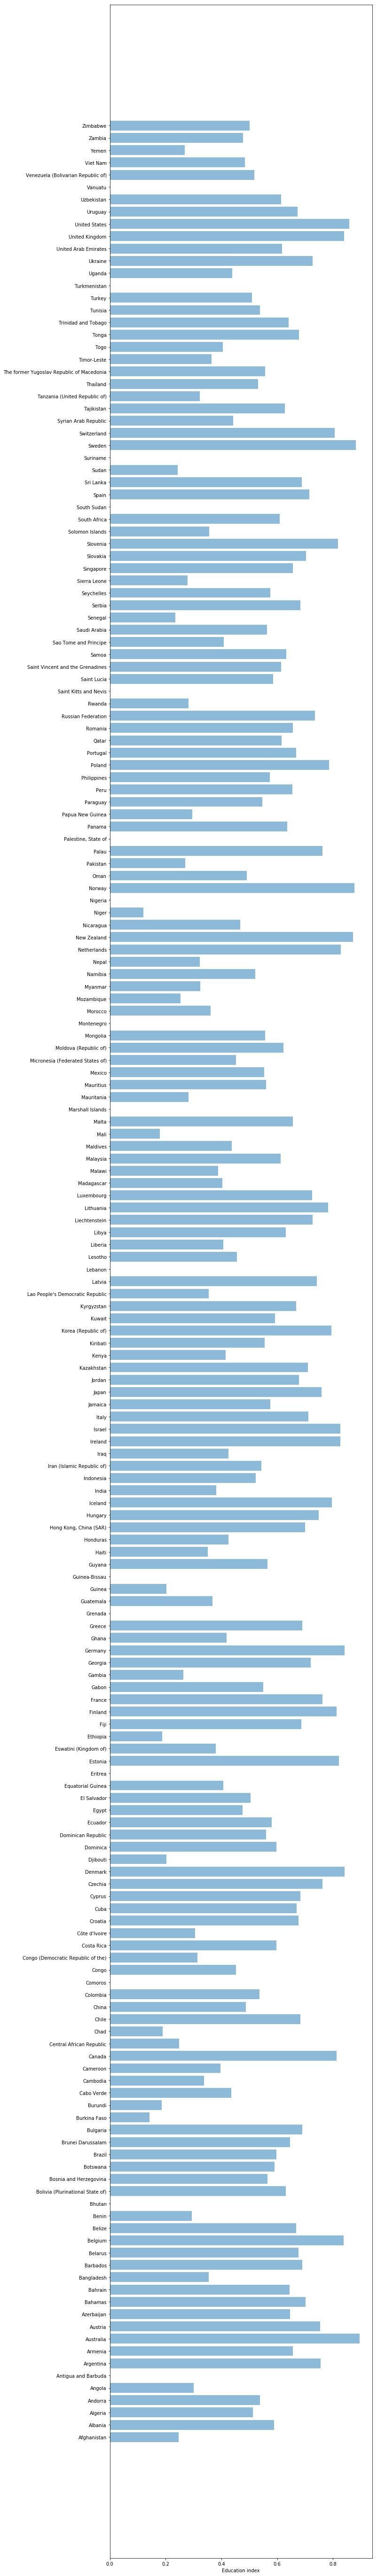

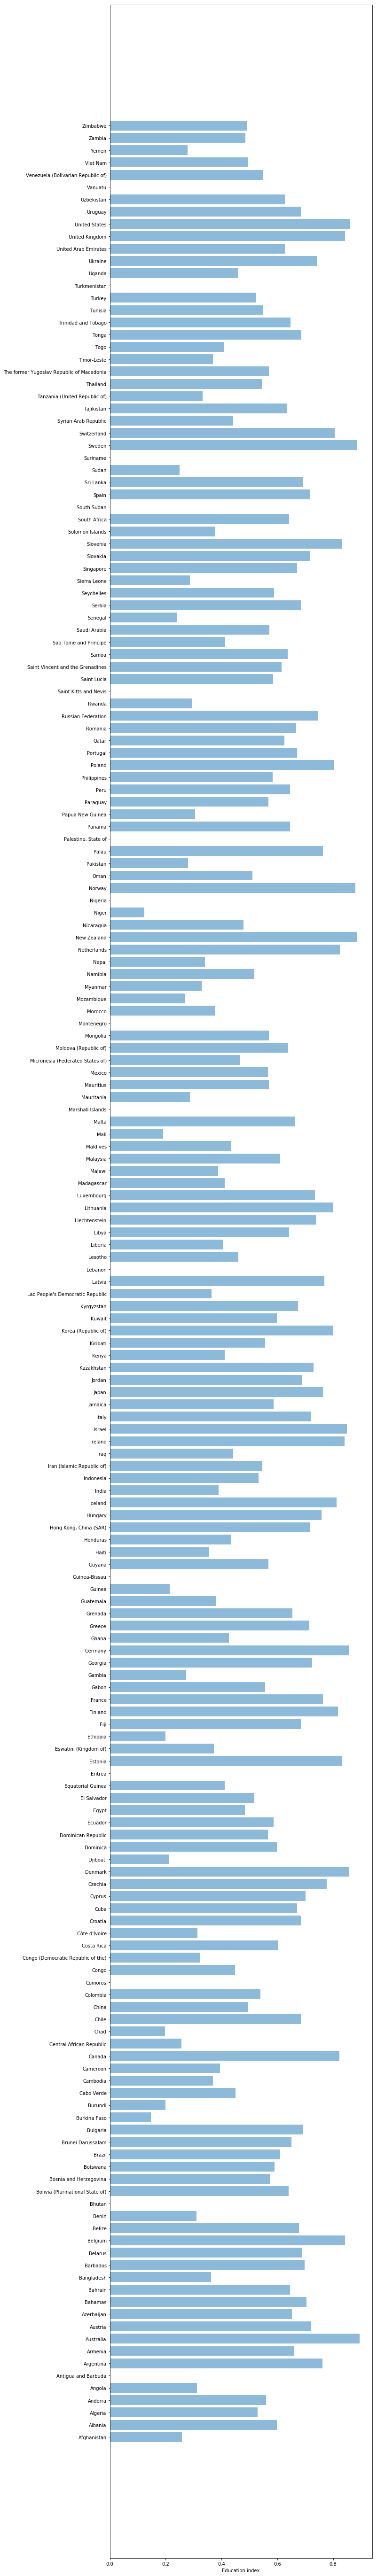

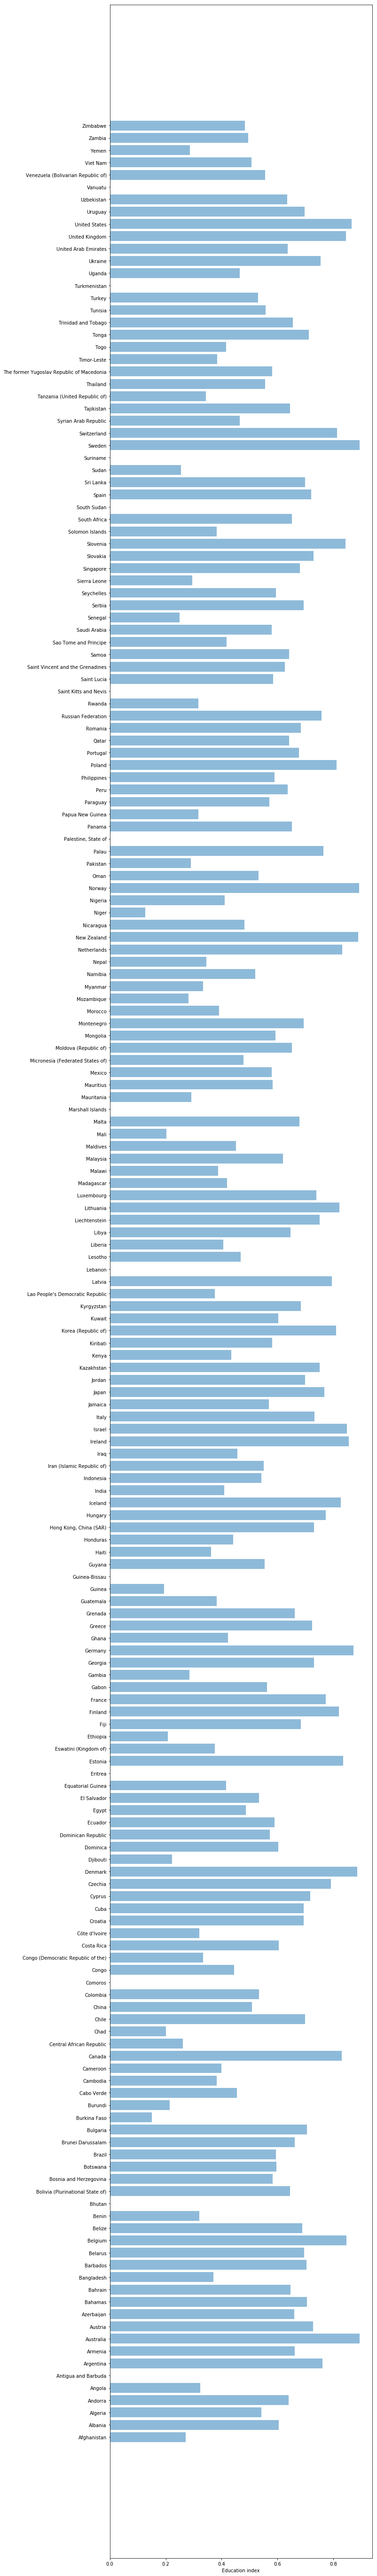

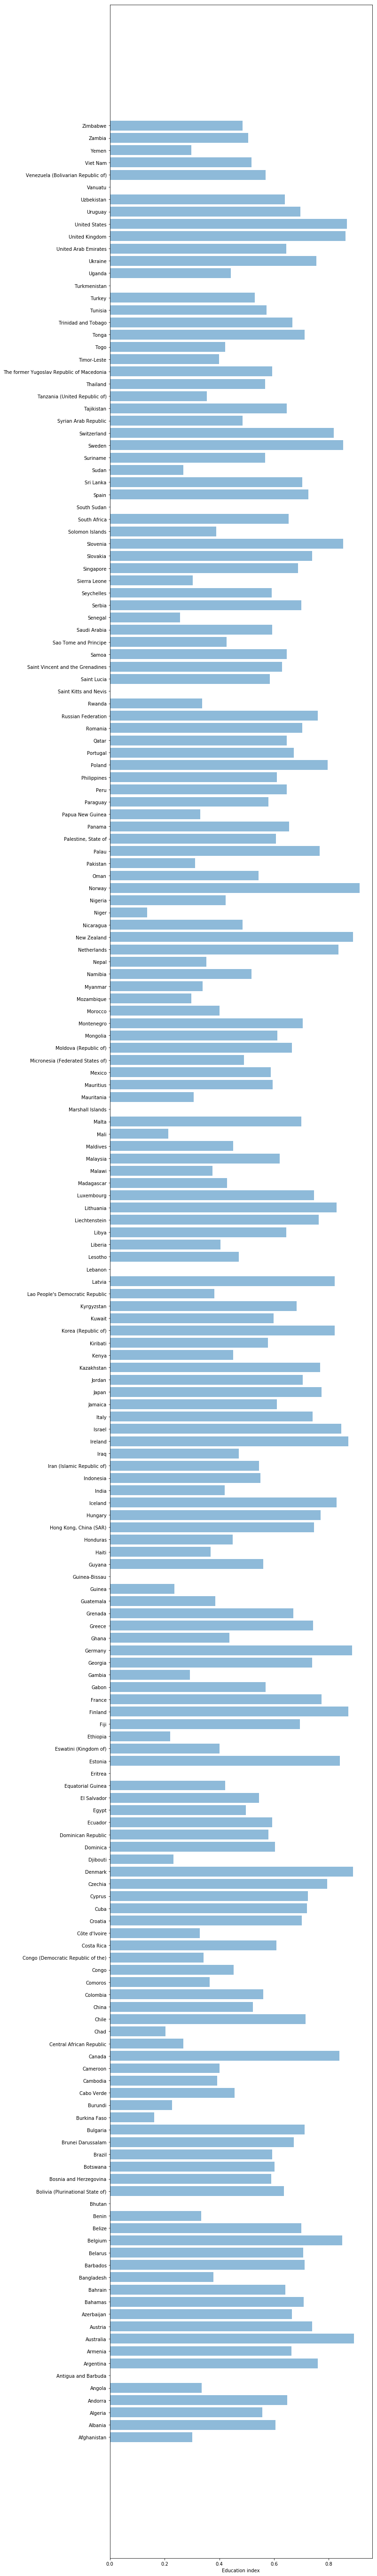

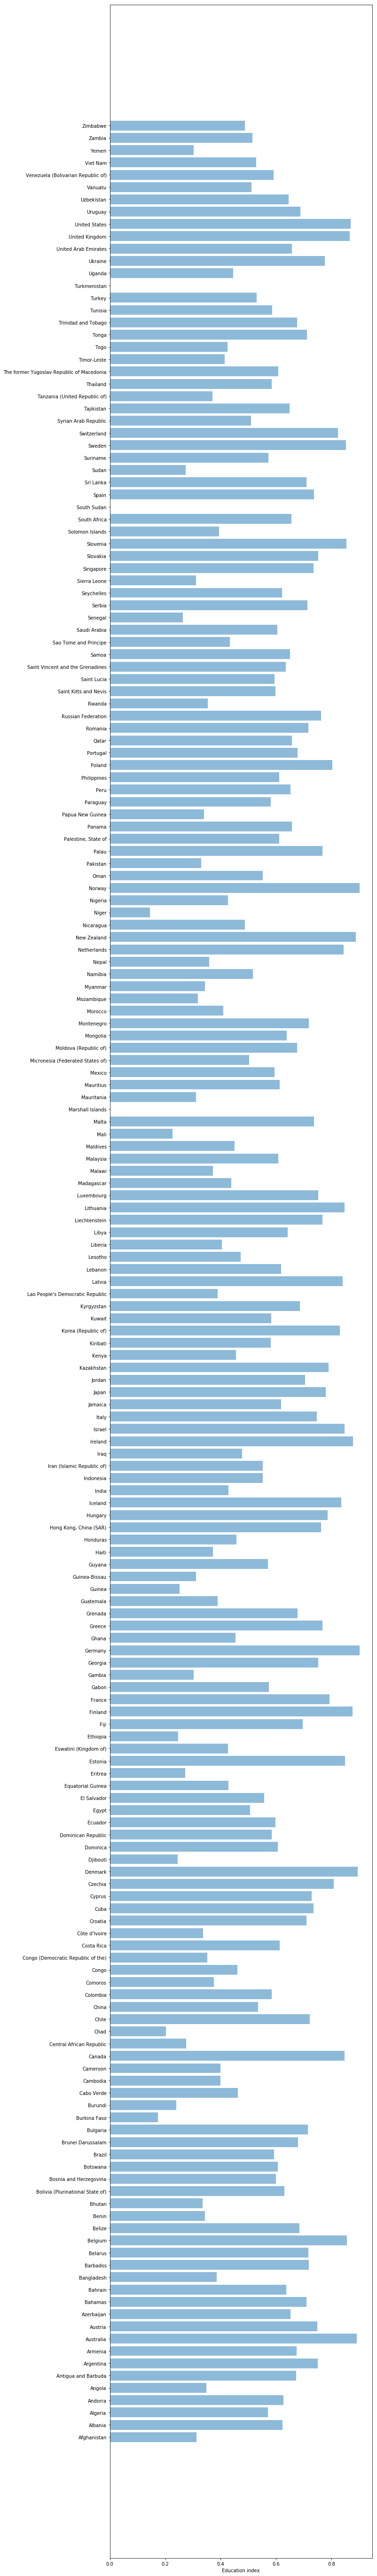

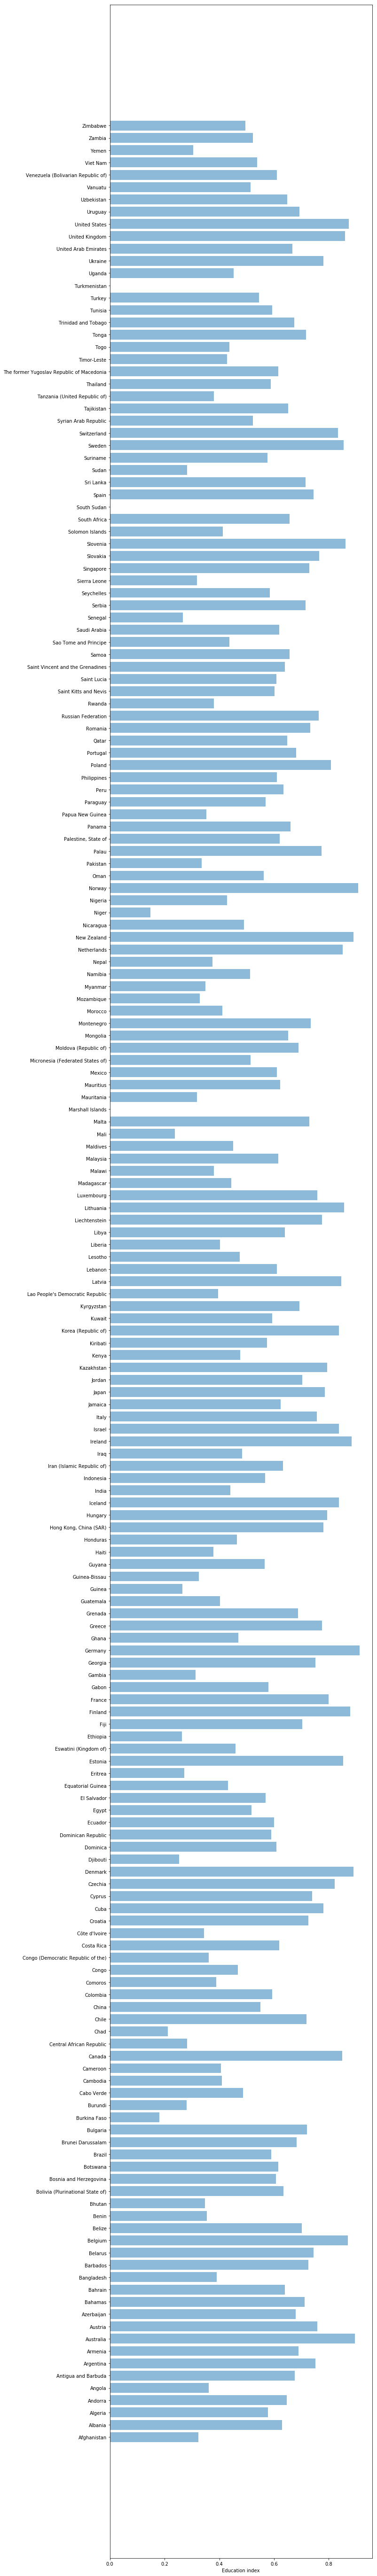

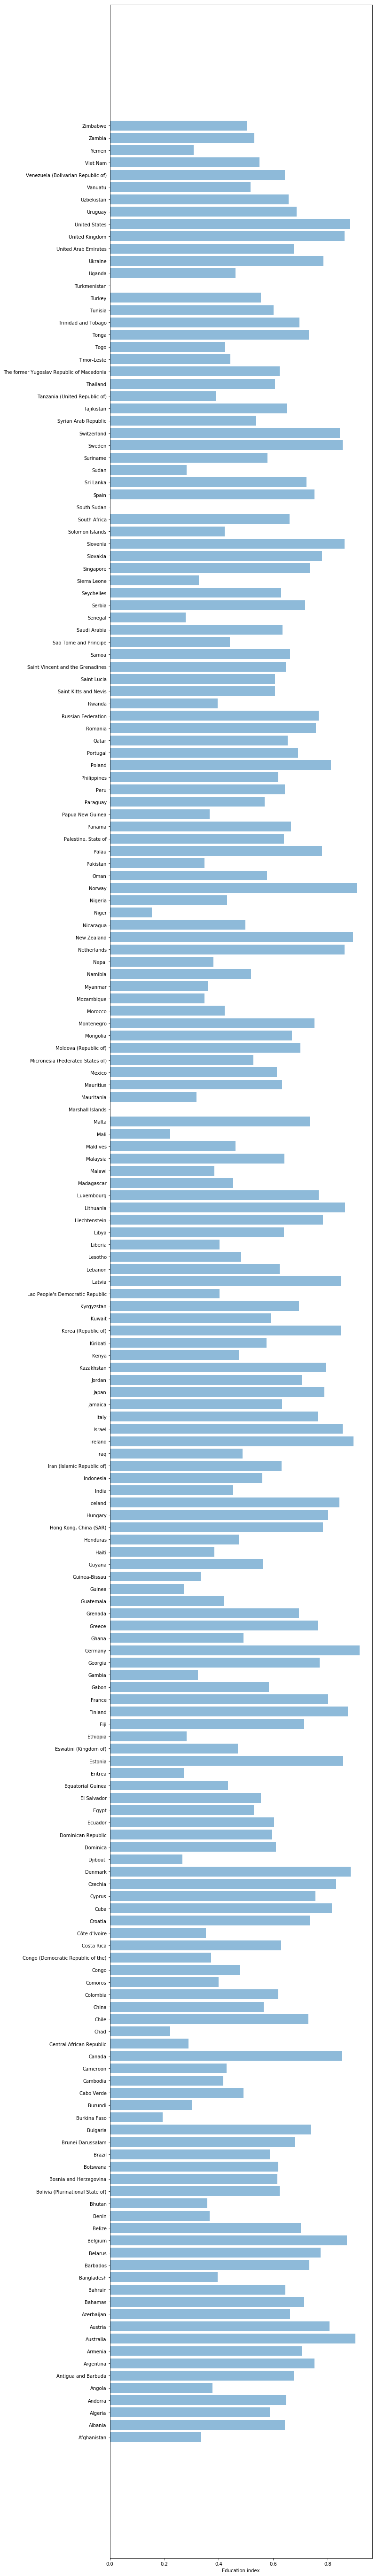

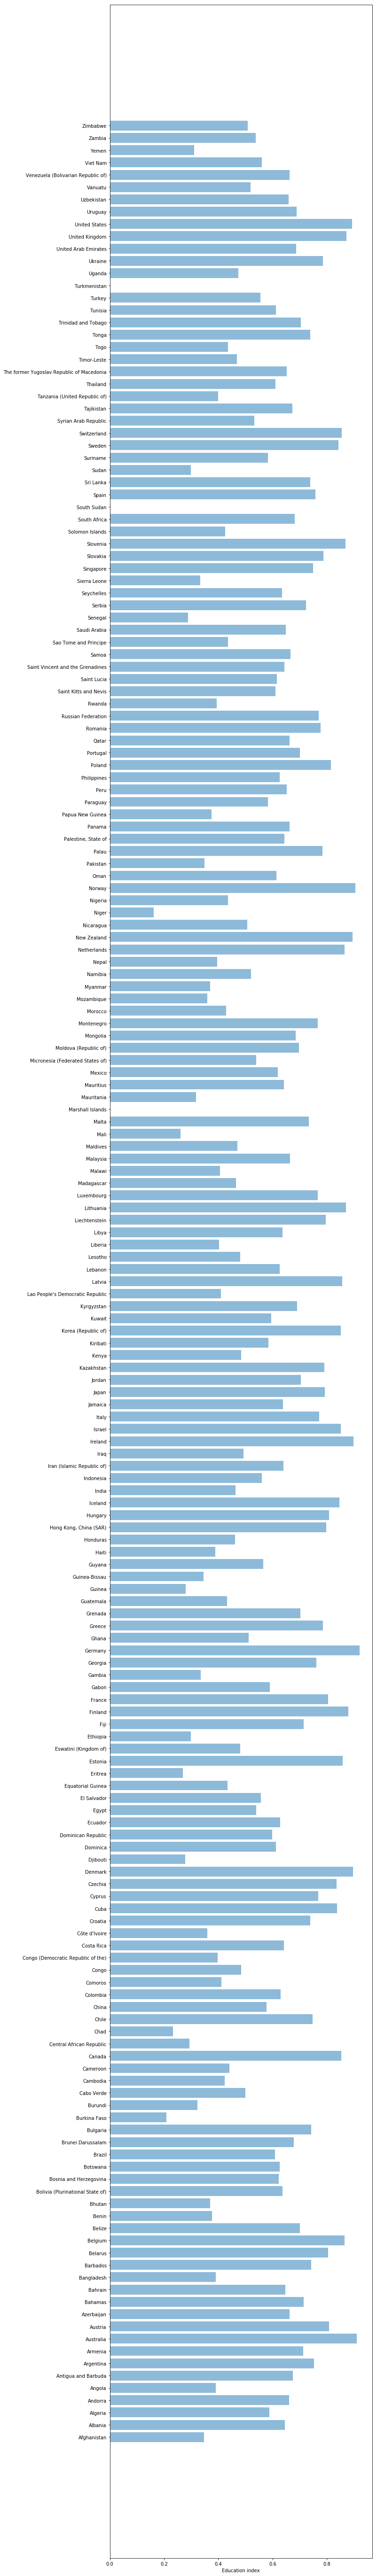

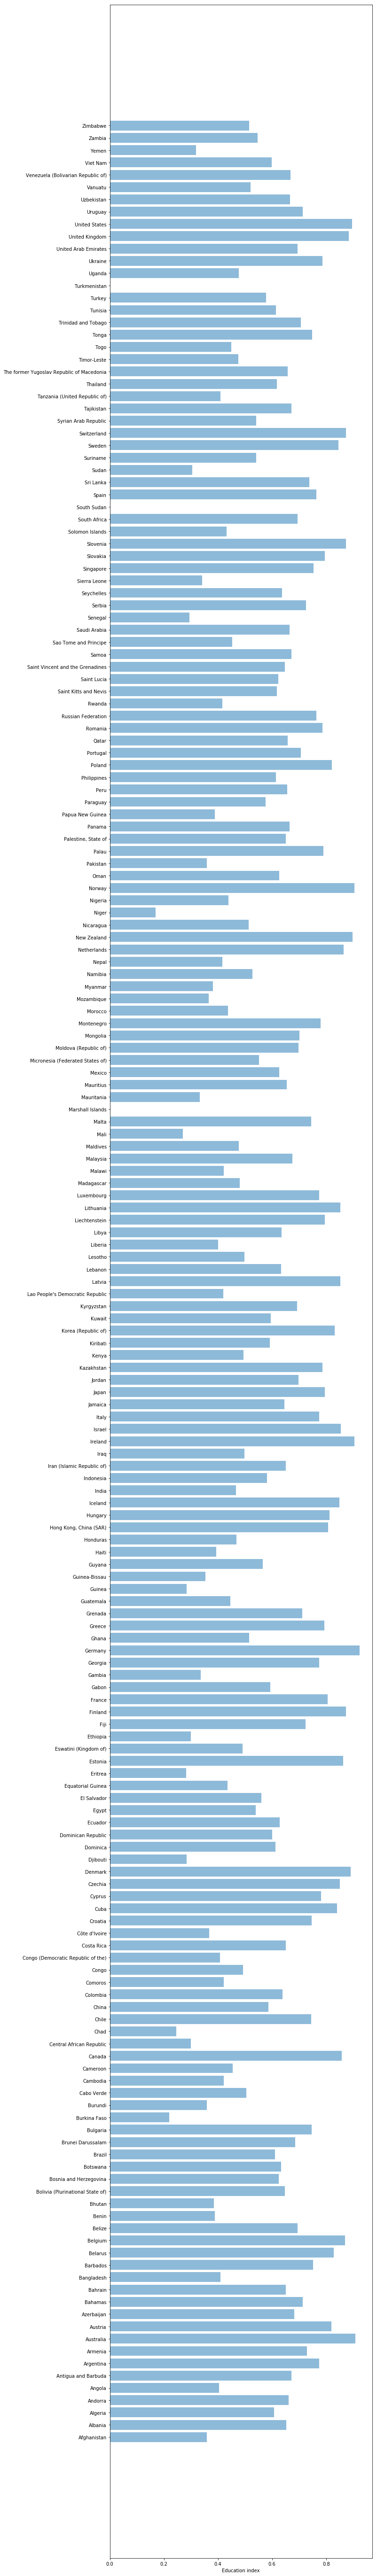

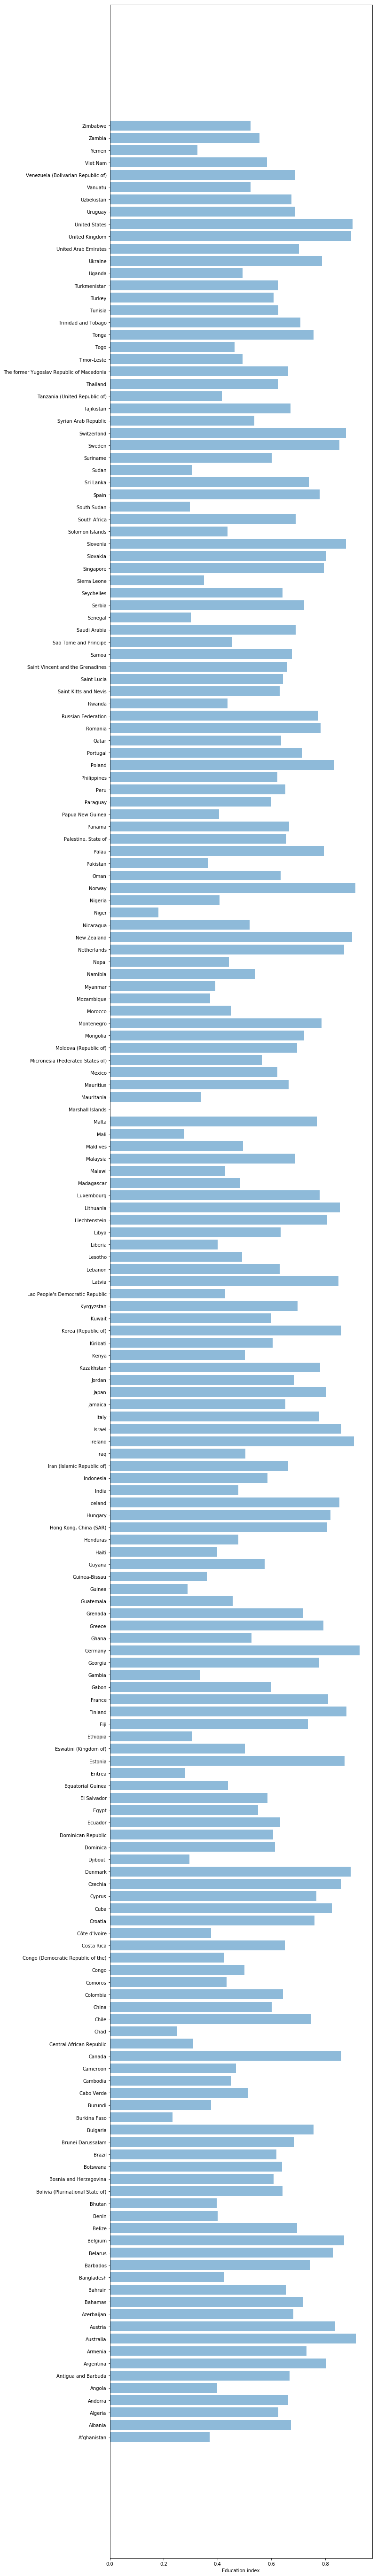

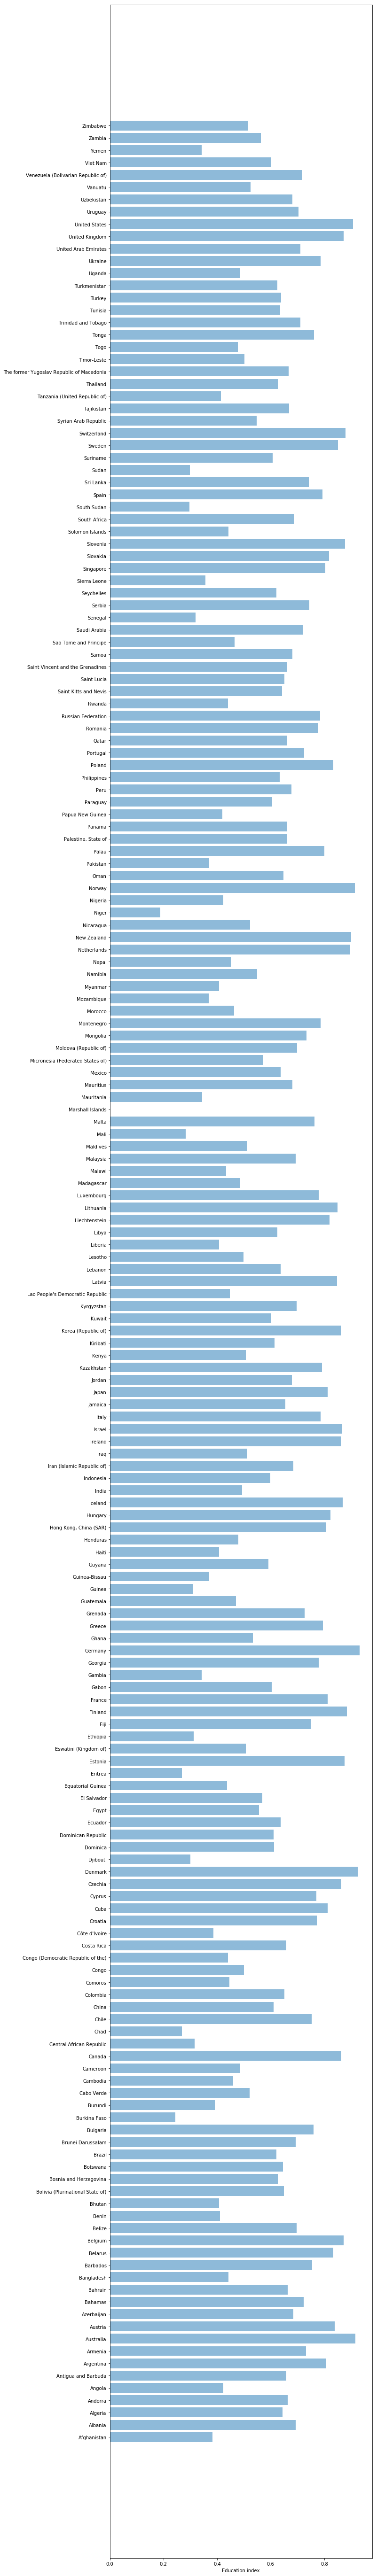

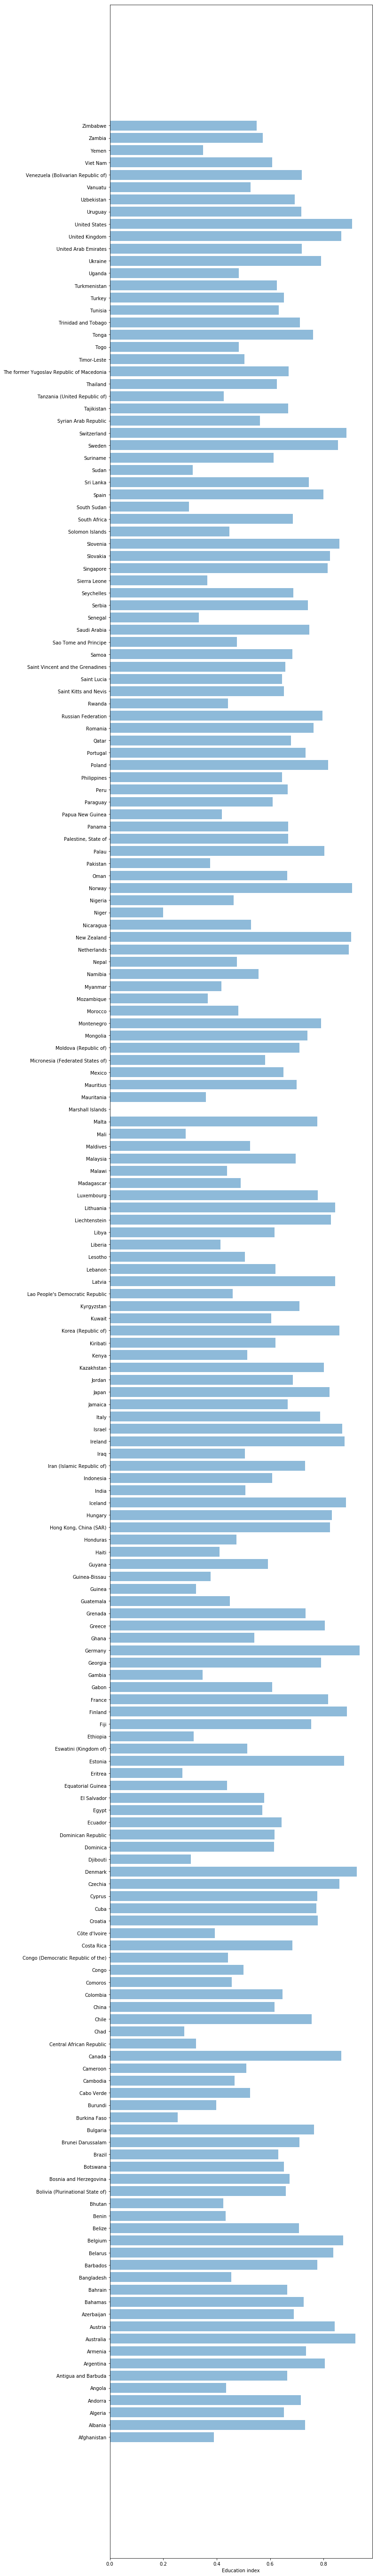

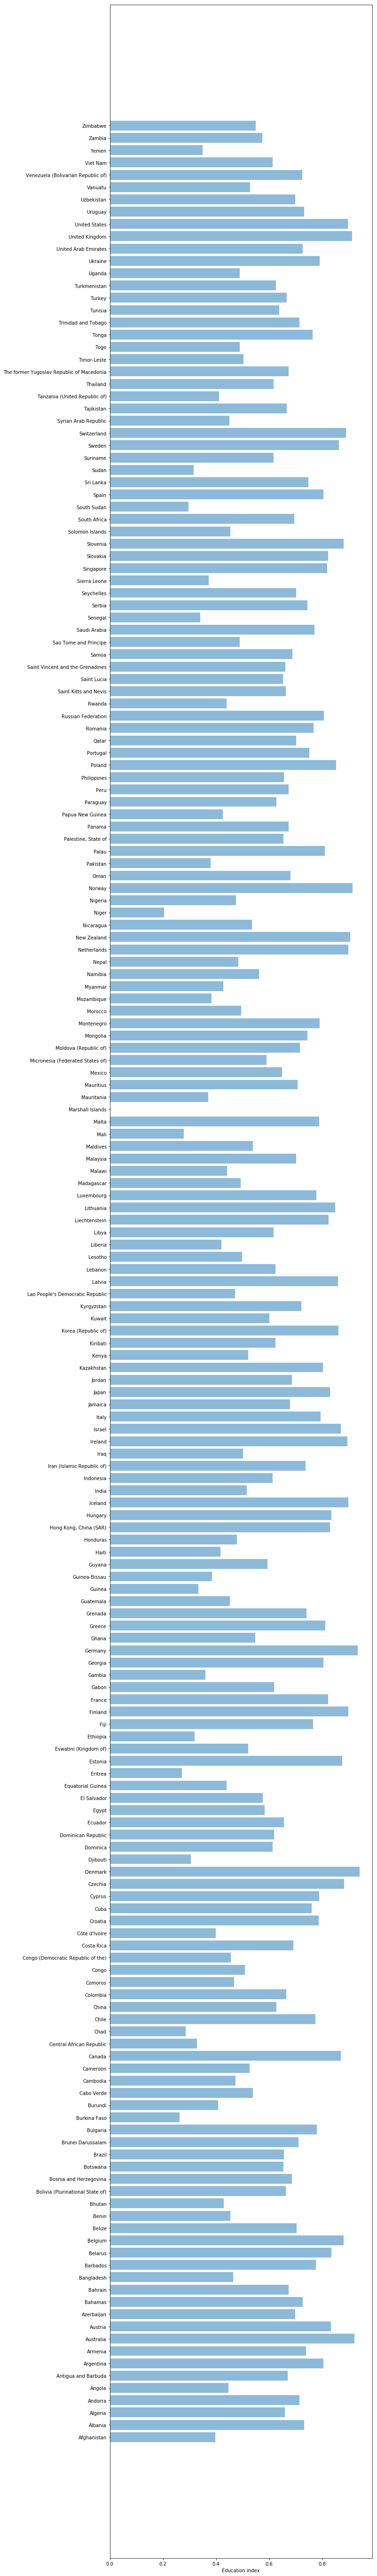

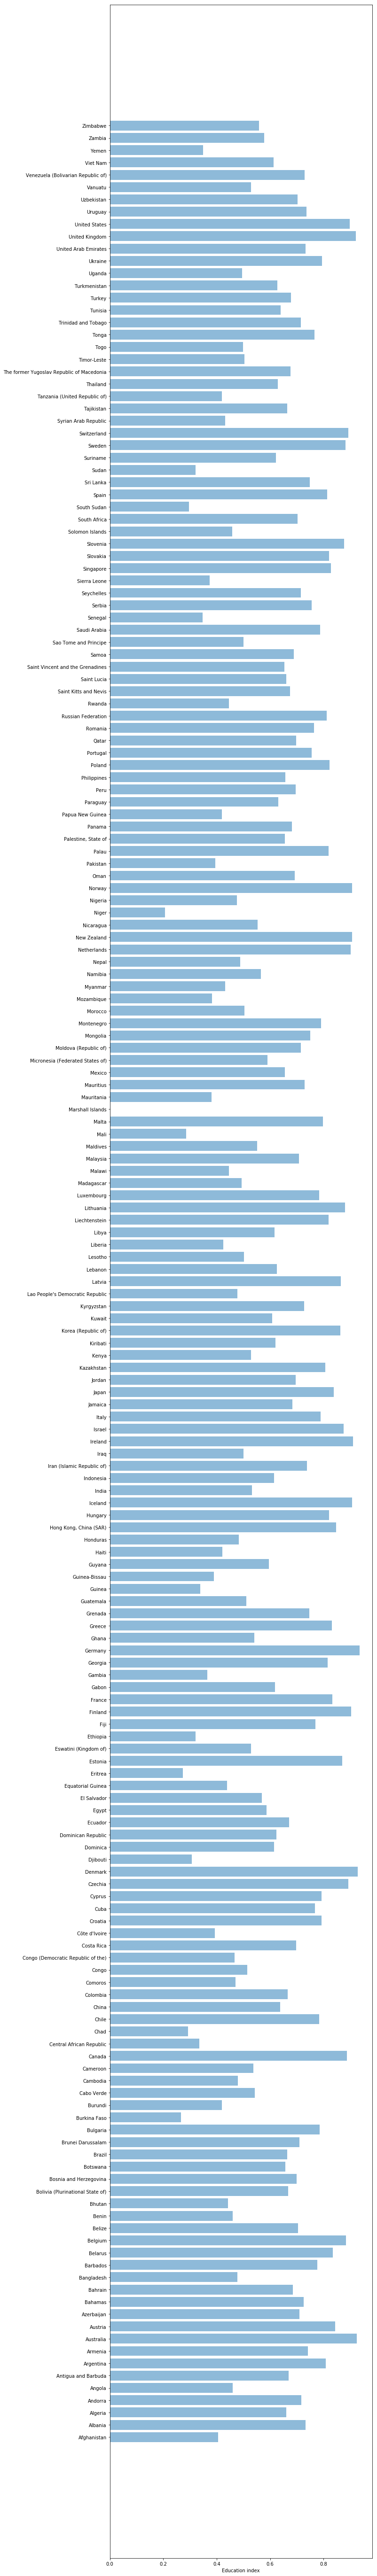

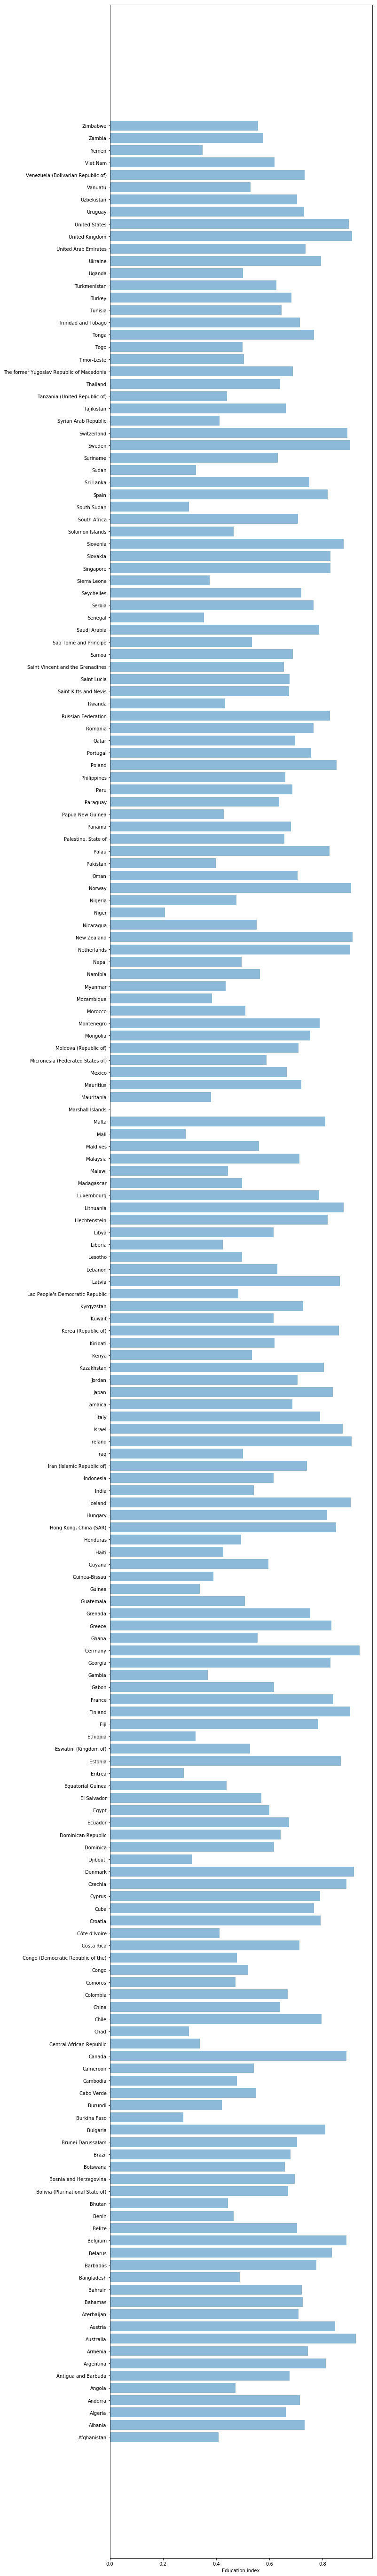

In [ ]:
plot_education_index(full_inds_df)

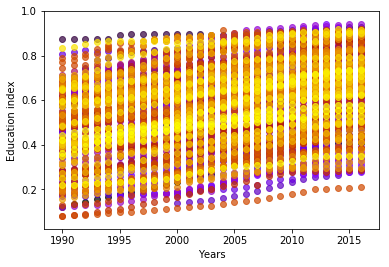

In [11]:
plot_education_index(full_inds_df)

In [7]:
full_inds_df[full_inds_df.indicator_name == "Education index"]

dimension  indicator_id   indicator_name iso3  \
2063  Education        103706  Education index  AFG   
2064  Education        103706  Education index  ALB   
2065  Education        103706  Education index  DZA   
2066  Education        103706  Education index  AND   
2067  Education        103706  Education index  AGO   
2068  Education        103706  Education index  ATG   
2069  Education        103706  Education index  ARG   
2070  Education        103706  Education index  ARM   
2071  Education        103706  Education index  AUS   
2072  Education        103706  Education index  AUT   
2073  Education        103706  Education index  AZE   
2074  Education        103706  Education index  BHS   
2075  Education        103706  Education index  BHR   
2076  Education        103706  Education index  BGD   
2077  Education        103706  Education index  BRB   
2078  Education        103706  Education index  BLR   
2079  Education        103706  Education index  BEL   
2080  Education        103706  Education index  BLZ   
2081  Education        103706  Education index  BEN   
2082  Education        103706  Education index  BTN   
2083  Education        103706  Education index  BOL   
2084  Education        103706  Education index  BIH   
2085  Education        103706  Education index  BWA   
2086  Education        103706  Education index  BRA   
2087  Education        103706  Education index  BRN   
2088  Education        103706  Education index  BGR   
2089  Education        103706  Education index  BFA   
2090  Education        103706  Education index  BDI   
2091  Education        103706  Education index  CPV   
2092  Education        103706  Education index  KHM   
...         ...           ...              ...  ...   
2222  Education        103706  Education index  LKA   
2223  Education        103706  Education index  SDN   
2224  Education        103706  Education index  SUR   
2225  Education        103706  Education index  SWE   
2226  Education        103706  Education index  CHE   
2227  Education        103706  Education index  SYR   
2228  Education        103706  Education index  TJK   
2229  Education        103706  Education index  TZA   
2230  Education        103706  Education index  THA   
2231  Education        103706  Education index  MKD   
2232  Education        103706  Education index  TLS   
2233  Education        103706  Education index  TGO   
2234  Education        103706  Education index  TON   
2235  Education        103706  Education index  TTO   
2236  Education        103706  Education index  TUN   
2237  Education        103706  Education index  TUR   
2238  Education        103706  Education index  TKM   
2239  Education        103706  Education index  UGA   
2240  Education        103706  Education index  UKR   
2241  Education        103706  Education index  ARE   
2242  Education        103706  Education index  GBR   
2243  Education        103706  Education index  USA   
2244  Education        103706  Education index  URY   
2245  Education        103706  Education index  UZB   
2246  Education        103706  Education index  VUT   
2247  Education        103706  Education index  VEN   
2248  Education        103706  Education index  VNM   
2249  Education        103706  Education index  YEM   
2250  Education        103706  Education index  ZMB   
2251  Education        103706  Education index  ZWE   

                                   country_name   1990   1991   1992   1993  \
2063                                Afghanistan  0.122  0.133  0.145  0.156   
2064                                    Albania  0.584  0.589  0.558  0.543   
2065                                    Algeria  0.385  0.395  0.405  0.414   
2066                                    Andorra    NaN    NaN    NaN    NaN   
2067                                     Angola    NaN    NaN    NaN    NaN   
2068                        Antigua and Barbuda    NaN    NaN    NaN    NaN   
2069                                  Arge

HDI rank
Human Development Index (HDI)
Median age (years)
Old-age (65 and older) dependency ratio (per 100 people ages 15-64)
Population ages 15–64 (millions)
Population ages 65 and older (millions)
Population under age 5 (millions)
Sex ratio at birth (male to female births)
Total population (millions)
Urban population (%)
Young age (0-14) dependency ratio (per 100 people ages 15-64)
Education index
Expected years of schooling (years)
Expected years of schooling, female (years)
Expected years of schooling, male (years)
Gross enrolment ratio, pre-primary (% of preschool-age children)
Gross enrolment ratio, primary (% of primary school-age population)
Gross enrolment ratio, secondary (% of secondary school-age population)
Gross enrolment ratio, tertiary (% of tertiary school-age population)
Literacy rate, adult (% ages 15 and older)
Mean years of schooling (years)
Mean years of schooling, female (years)


/home/xubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
/home/xubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
/home/xubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
/home/xubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned


Mean years of schooling, male (years)
Primary school dropout rate (% of primary school cohort)
Primary school teachers trained to teach (%)
Pupil-teacher ratio, primary school (pupils per teacher)
Carbon dioxide emissions (kg per 2011 PPP $ of GDP)
Carbon dioxide emissions, per capita (tonnes)
Forest area (% of total land area)
Forest area, change (%)
Fossil fuel energy consumption (% of total energy consumption)
Fresh water withdrawals (% of total renewable water resources)
Mortality rate attributed to household and ambient air pollution (per 100,000 population)
Mortality rate attributed to unsafe water, sanitation and hygiene services (per 100,000 population)
Red List Index (value)
Renewable energy consumption (% of total final energy consumption)
Adolescent birth rate (births per 1,000 women ages 15-19)
Antenatal care coverage, at least one visit (%)
Child marriage, women married by age 18 (% of women ages 20–24 years who are married or in union)
Contraceptive prevalence, any method

/home/xubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned


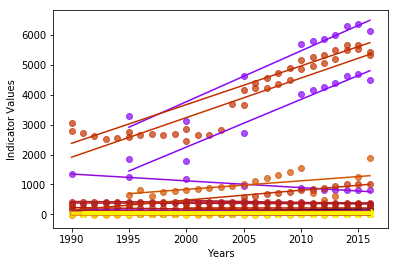

In [24]:
plot_indicators_vs_year(full_inds_df, "Nigeria")

In [ ]:
def bar_plot(df):
    new_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    new_df = new_df[new_df.indicator_name == "Education index"]
    number = len(new_df)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, number)]
    color_index = 0
    all_x = []
    all_y = []
    while len(new_df) > 0:
        temp = new_df.iloc[0]
        #print(temp["indicator_name"])
        x_vals = []
        y_vals = []
        for year in range(1990, 2017):
            if str(temp[str(year)]) != "nan":
                x_vals.append(year)
                y_vals.append(temp[str(year)])
        plt.xlabel("Years")
        plt.ylabel("Education index")
        plt.scatter(x_vals, y_vals, color = colors[color_index], alpha = .7)
        color_index += 1
        new_df = new_df.iloc[1:,]

In [10]:
len(full_inds_df)

25636

In [11]:
full_inds_df

dimension  indicator_id  \
0                       Composite indices        146206   
1                       Composite indices        146206   
2                       Composite indices        146206   
3                       Composite indices        146206   
4                       Composite indices        146206   
5                       Composite indices        146206   
6                       Composite indices        146206   
7                       Composite indices        146206   
8                       Composite indices        146206   
9                       Composite indices        146206   
10                      Composite indices        146206   
11                      Composite indices        146206   
12                      Composite indices        146206   
13                      Composite indices        146206   
14                      Composite indices        146206   
15                      Composite indices        146206   
16                      Composite indices        146206   
17                      Composite indices        146206   
18                      Composite indices        146206   
19                      Composite indices        146206   
20                      Composite indices        146206   
21                      Composite indices        146206   
22                      Composite indices        146206   
23                      Composite indices        146206   
24                      Composite indices        146206   
25                      Composite indices        146206   
26                      Composite indices        146206   
27                      Composite indices        146206   
28                      Composite indices        146206   
29                      Composite indices        146206   
...                                   ...           ...   
25606  Work, employment and vulnerability        147906   
25607  Work, employment and vulnerability        147906   
25608  Work, employment and vulnerability        147906   
25609  Work, employment and vulnerability        147906   
25610  Work, employment and vulnerability        147906   
25611  Work, employment and vulnerability        147906   
25612  Work, employment and vulnerability        147906   
25613  Work, employment and vulnerability        147906   
25614  Work, employment and vulnerability        147906   
25615  Work, employment and vulnerability        147906   
25616  Work, employment and vulnerability        147906   
25617  Work, employment and vulnerability        147906   
25618  Work, employment and vulnerability        147906   
25619  Work, employment and vulnerability        147906   
25620  Work, employment and vulnerability        147906   
25621  Work, employment and vulnerability        147906   
25622  Work, employment and vulnerability        147906   
25623  Work, employment and vulnerability        147906   
25624  Work, employment and vulnerability        147906   
25625  Work, employment and vulnerability        147906   
25626  Work, employment and vulnerability        147906   
25627  Work, employment and vulnerability        147906   
25628  Work, employment and vulnerability        147906   
25629  Work, employment and vulnerability        147906   
25630  Work, employment and vulnerability        147906   
25631  Work, employment and vulnerability        147906   
25632  Work, employment and vulnerability        147906   
25633  Work, employment and vulnerability        147906   
25634  Work, employment and vulnerability        147906   
25635  Work, employment and vulnerability        147906   

                                         indicator_name iso3  \
0                                              HDI rank  AFG   
1                                              HDI rank  ALB   
2                                              HDI rank  DZA   
3                                              HDI rank  AND   
4                                              HDI ra

In [157]:
full_inds_df["indicator_name"].unique()

array(['HDI rank', 'Human Development Index (HDI)', 'Median age (years)',
       'Old-age (65 and older) dependency ratio (per 100 people ages 15-64)',
       'Population ages 15–64 (millions)',
       'Population ages 65 and older (millions)',
       'Population under age 5 (millions)',
       'Sex ratio at birth (male to female births)',
       'Total population (millions)', 'Urban population (%)',
       'Young age (0-14) dependency ratio (per 100 people ages 15-64)',
       'Education index', 'Expected years of schooling (years)',
       'Expected years of schooling, female (years)',
       'Expected years of schooling, male (years)',
       'Government expenditure on education (% of GDP)',
       'Gross enrolment ratio, pre-primary (% of preschool-age children)',
       'Gross enrolment ratio, primary (% of primary school-age population)',
       'Gross enrolment ratio, secondary (% of secondary school-age population)',
       'Gross enrolment ratio, tertiary (% of tertiary school

In [201]:
inds_df["indicator_name"].unique()
#inds_df.iloc[0, 0]
#inds_df[inds_df.country_name == "Afghanistan"][]

array(['Human Development Index (HDI)',
       'Old-age (65 and older) dependency ratio (per 100 people ages 15-64)',
       'Population ages 15–64 (millions)',
       'Population ages 65 and older (millions)',
       'Population under age 5 (millions)', 'Total population (millions)',
       'Urban population (%)',
       'Young age (0-14) dependency ratio (per 100 people ages 15-64)',
       'Education index', 'Expected years of schooling (years)',
       'Expected years of schooling, female (years)',
       'Expected years of schooling, male (years)',
       'Mean years of schooling (years)',
       'Mean years of schooling, female (years)',
       'Mean years of schooling, male (years)',
       'Population with at least some secondary education, female (% ages 25 and older)',
       'Population with at least some secondary education, male (% ages 25 and older)',
       'Estimated gross national income per capita, female (2011 PPP $)',
       'Estimated gross national income per capi

In [43]:
inds_df

dimension  indicator_id  \
190            Composite indices        137506   
191            Composite indices        137506   
195            Composite indices        137506   
196            Composite indices        137506   
197            Composite indices        137506   
198            Composite indices        137506   
199            Composite indices        137506   
201            Composite indices        137506   
202            Composite indices        137506   
203            Composite indices        137506   
204            Composite indices        137506   
205            Composite indices        137506   
206            Composite indices        137506   
207            Composite indices        137506   
209            Composite indices        137506   
211            Composite indices        137506   
212            Composite indices        137506   
213            Composite indices        137506   
214            Composite indices        137506   
216            Composite indices        137506   
218            Composite indices        137506   
219            Composite indices        137506   
220            Composite indices        137506   
221            Composite indices        137506   
223            Composite indices        137506   
224            Composite indices        137506   
225            Composite indices        137506   
227            Composite indices        137506   
228            Composite indices        137506   
229            Composite indices        137506   
...                          ...           ...   
23591  Trade and financial flows         52606   
23592  Trade and financial flows         52606   
23593  Trade and financial flows         52606   
23594  Trade and financial flows         52606   
23597  Trade and financial flows         52606   
23599  Trade and financial flows         52606   
23600  Trade and financial flows         52606   
23601  Trade and financial flows         52606   
23602  Trade and financial flows         52606   
23604  Trade and financial flows         52606   
23606  Trade and financial flows         52606   
23607  Trade and financial flows         52606   
23608  Trade and financial flows         52606   
23609  Trade and financial flows         52606   
23610  Trade and financial flows         52606   
23611  Trade and financial flows         52606   
23614  Trade and financial flows         52606   
23615  Trade and financial flows         52606   
23616  Trade and financial flows         52606   
23618  Trade and financial flows         52606   
23619  Trade and financial flows         52606   
23620  Trade and financial flows         52606   
23621  Trade and financial flows         52606   
23622  Trade and financial flows         52606   
23626  Trade and financial flows         52606   
23627  Trade and financial flows         52606   
23628  Trade and financial flows         52606   
23631  Trade and financial flows         52606   
23632  Trade and financial flows         52606   
23634  Trade and financial flows         52606   

                        indicator_name iso3  \
190      Human Development Index (HDI)  ALB   
191      Human Development Index (HDI)  DZA   
195      Human Development Index (HDI)  ARG   
196      Human Development Index (HDI)  ARM   
197      Human Development Index (HDI)  AUS   
198      Human Development Index (HDI)  AUT   
199      Human Development Index (HDI)  AZE   
201      Human Development Index (HDI)  BHR   
202      Human Development Index (HDI)  BGD   
203      Human Development Index (HDI)  BRB   
204      Human Development Index (HDI)  BLR   
205      Human Development Index (HDI)  BEL   
206      Human Development Index (HDI)  BLZ   
207      Human Development Index (HDI)  BEN   
209      Human Development Index (HDI)  BOL   
211      Human Development Index (HDI)  BWA   
212      Human Development Index (HDI)  BRA   
213      Human Development Index (HDI)  BRN   
214      Human Development In

In [19]:
test = inds_df.drop(inds_df.columns[[0, 1, 3]], axis=1)[inds_df.country_name == "United States"].T
test


1990                             0.860000      \
indicator_name  Human Development Index (HDI)   
country_name                    United States   
1990                                     0.86   
1991                                    0.861   
1992                                    0.867   
1993                                    0.871   
1994                                    0.875   
1995                                    0.877   
1996                                    0.879   
1997                                    0.881   
1998                                    0.884   
1999                                    0.885   
2000                                    0.885   
2001                                    0.887   
2002                                    0.889   
2003                                    0.892   
2004                                    0.895   
2005                                    0.898   
2006                                    0.901   
2007                                    0.905   
2008                                     0.91   
2009                                     0.91   
2010                                    0.914   
2011                                    0.917   
2012                                    0.918   
2013                                    0.916   
2014                                    0.918   
2015                                     0.92   
2016                                    0.922   
2017                                    0.924   

1990                                                 19.200000     \
indicator_name  Old-age (65 and older) dependency ratio (per 1...   
country_name                                        United States   
1990                                                         19.2   
1991                                                         19.3   
1992                                                         19.4   
1993                                                         19.4   
1994                                                         19.4   
1995                                                         19.4   
1996                                                         19.3   
1997                                                         19.1   
1998                                                           19   
1999                                                         18.8   
2000                                                         18.7   
2001                                                         18.6   
2002                                                         18.5   
2003                                                         18.4   
2004                                                         18.4   
2005                                                         18.4   
2006                                                         18.5   
2007                                                         18.6   
2008                                                         18.8   
2009                                                         19.1   
2010                                                         19.4   
2011                                                         19.8   
2012                                                         20.3   
2013                                                         20.9   
2014                                                         21.5   
2015                                                         22.1   
2016                                                         22.8   
2017                                                         23.5   

1990                                165.900000    \
indicator_name  Population ages 15–64 (millions)   
country_name                       United States   
1990                                       165.9   
1991                                       167.1   
1992                                       168.3   
1993                        

In [20]:
test.columns = test.iloc[0]
test

indicator_name  Human Development Index (HDI)  \
indicator_name  Human Development Index (HDI)   
country_name                    United States   
1990                                     0.86   
1991                                    0.861   
1992                                    0.867   
1993                                    0.871   
1994                                    0.875   
1995                                    0.877   
1996                                    0.879   
1997                                    0.881   
1998                                    0.884   
1999                                    0.885   
2000                                    0.885   
2001                                    0.887   
2002                                    0.889   
2003                                    0.892   
2004                                    0.895   
2005                                    0.898   
2006                                    0.901   
2007                                    0.905   
2008                                     0.91   
2009                                     0.91   
2010                                    0.914   
2011                                    0.917   
2012                                    0.918   
2013                                    0.916   
2014                                    0.918   
2015                                     0.92   
2016                                    0.922   
2017                                    0.924   

indicator_name Old-age (65 and older) dependency ratio (per 100 people ages 15-64)  \
indicator_name  Old-age (65 and older) dependency ratio (per 1...                    
country_name                                        United States                    
1990                                                         19.2                    
1991                                                         19.3                    
1992                                                         19.4                    
1993                                                         19.4                    
1994                                                         19.4                    
1995                                                         19.4                    
1996                                                         19.3                    
1997                                                         19.1                    
1998                                                           19                    
1999                                                         18.8                    
2000                                                         18.7                    
2001                                                         18.6                    
2002                                                         18.5                    
2003                                                         18.4                    
2004                                                         18.4                    
2005                                                         18.4                    
2006                                                         18.5                    
2007                                                         18.6                    
2008                                                         18.8                    
2009                                                         19.1                    
2010                                                         19.4                    
2011                                                         19.8                    
2012                                                         20.3                    
2013                                                         20.9                    
2014                                                         21.5                    
2015                                                         22.1       

In [21]:
test = test[2:]
test

indicator_name  Human Development Index (HDI)  \
1990                                    0.860   
1991                                    0.861   
1992                                    0.867   
1993                                    0.871   
1994                                    0.875   
1995                                    0.877   
1996                                    0.879   
1997                                    0.881   
1998                                    0.884   
1999                                    0.885   
2000                                    0.885   
2001                                    0.887   
2002                                    0.889   
2003                                    0.892   
2004                                    0.895   
2005                                    0.898   
2006                                    0.901   
2007                                    0.905   
2008                                    0.910   
2009                                    0.910   
2010                                    0.914   
2011                                    0.917   
2012                                    0.918   
2013                                    0.916   
2014                                    0.918   
2015                                    0.920   
2016                                    0.922   
2017                                    0.924   

indicator_name  Old-age (65 and older) dependency ratio (per 100 people ages 15-64)  \
1990                                                         19.2                     
1991                                                         19.3                     
1992                                                         19.4                     
1993                                                         19.4                     
1994                                                         19.4                     
1995                                                         19.4                     
1996                                                         19.3                     
1997                                                         19.1                     
1998                                                         19.0                     
1999                                                         18.8                     
2000                                                         18.7                     
2001                                                         18.6                     
2002                                                         18.5                     
2003                                                         18.4                     
2004                                                         18.4                     
2005                                                         18.4                     
2006                                                         18.5                     
2007                                                         18.6                     
2008                                                         18.8                     
2009                                                         19.1                     
2010                                                         19.4                     
2011                                                         19.8                     
2012                                                         20.3                     
2013                                                         20.9                     
2014                                                         21.5                     
2015                                                         22.1                     
2016                                                         22.8                     
2017                                                         23.5                     

indicator_name  Population ages 15–64 (millions)  \
19

In [22]:
test = test.apply(pd.to_numeric)
test

indicator_name  Human Development Index (HDI)  \
1990                                    0.860   
1991                                    0.861   
1992                                    0.867   
1993                                    0.871   
1994                                    0.875   
1995                                    0.877   
1996                                    0.879   
1997                                    0.881   
1998                                    0.884   
1999                                    0.885   
2000                                    0.885   
2001                                    0.887   
2002                                    0.889   
2003                                    0.892   
2004                                    0.895   
2005                                    0.898   
2006                                    0.901   
2007                                    0.905   
2008                                    0.910   
2009                                    0.910   
2010                                    0.914   
2011                                    0.917   
2012                                    0.918   
2013                                    0.916   
2014                                    0.918   
2015                                    0.920   
2016                                    0.922   
2017                                    0.924   

indicator_name  Old-age (65 and older) dependency ratio (per 100 people ages 15-64)  \
1990                                                         19.2                     
1991                                                         19.3                     
1992                                                         19.4                     
1993                                                         19.4                     
1994                                                         19.4                     
1995                                                         19.4                     
1996                                                         19.3                     
1997                                                         19.1                     
1998                                                         19.0                     
1999                                                         18.8                     
2000                                                         18.7                     
2001                                                         18.6                     
2002                                                         18.5                     
2003                                                         18.4                     
2004                                                         18.4                     
2005                                                         18.4                     
2006                                                         18.5                     
2007                                                         18.6                     
2008                                                         18.8                     
2009                                                         19.1                     
2010                                                         19.4                     
2011                                                         19.8                     
2012                                                         20.3                     
2013                                                         20.9                     
2014                                                         21.5                     
2015                                                         22.1                     
2016                                                         22.8                     
2017                                                         23.5                     

indicator_name  Population ages 15–64 (millions)  \
19

In [25]:
df_corr

indicator_name  Human Development Index (HDI)  \
1990                                    0.860   
1991                                    0.861   
1992                                    0.867   
1993                                    0.871   
1994                                    0.875   
1995                                    0.877   
1996                                    0.879   
1997                                    0.881   
1998                                    0.884   
1999                                    0.885   
2000                                    0.885   
2001                                    0.887   
2002                                    0.889   
2003                                    0.892   
2004                                    0.895   
2005                                    0.898   
2006                                    0.901   
2007                                    0.905   
2008                                    0.910   
2009                                    0.910   
2010                                    0.914   
2011                                    0.917   
2012                                    0.918   
2013                                    0.916   
2014                                    0.918   
2015                                    0.920   
2016                                    0.922   
2017                                    0.924   

indicator_name  Old-age (65 and older) dependency ratio (per 100 people ages 15-64)  \
1990                                                         19.2                     
1991                                                         19.3                     
1992                                                         19.4                     
1993                                                         19.4                     
1994                                                         19.4                     
1995                                                         19.4                     
1996                                                         19.3                     
1997                                                         19.1                     
1998                                                         19.0                     
1999                                                         18.8                     
2000                                                         18.7                     
2001                                                         18.6                     
2002                                                         18.5                     
2003                                                         18.4                     
2004                                                         18.4                     
2005                                                         18.4                     
2006                                                         18.5                     
2007                                                         18.6                     
2008                                                         18.8                     
2009                                                         19.1                     
2010                                                         19.4                     
2011                                                         19.8                     
2012                                                         20.3                     
2013                                                         20.9                     
2014                                                         21.5                     
2015                                                         22.1                     
2016                                                         22.8                     
2017                                                         23.5                     

indicator_name  Population ages 15–64 (millions)  \
19

In [32]:
inds_df

dimension  indicator_id  \
190            Composite indices        137506   
191            Composite indices        137506   
195            Composite indices        137506   
196            Composite indices        137506   
197            Composite indices        137506   
198            Composite indices        137506   
199            Composite indices        137506   
201            Composite indices        137506   
202            Composite indices        137506   
203            Composite indices        137506   
204            Composite indices        137506   
205            Composite indices        137506   
206            Composite indices        137506   
207            Composite indices        137506   
209            Composite indices        137506   
211            Composite indices        137506   
212            Composite indices        137506   
213            Composite indices        137506   
214            Composite indices        137506   
216            Composite indices        137506   
218            Composite indices        137506   
219            Composite indices        137506   
220            Composite indices        137506   
221            Composite indices        137506   
223            Composite indices        137506   
224            Composite indices        137506   
225            Composite indices        137506   
227            Composite indices        137506   
228            Composite indices        137506   
229            Composite indices        137506   
...                          ...           ...   
23591  Trade and financial flows         52606   
23592  Trade and financial flows         52606   
23593  Trade and financial flows         52606   
23594  Trade and financial flows         52606   
23597  Trade and financial flows         52606   
23599  Trade and financial flows         52606   
23600  Trade and financial flows         52606   
23601  Trade and financial flows         52606   
23602  Trade and financial flows         52606   
23604  Trade and financial flows         52606   
23606  Trade and financial flows         52606   
23607  Trade and financial flows         52606   
23608  Trade and financial flows         52606   
23609  Trade and financial flows         52606   
23610  Trade and financial flows         52606   
23611  Trade and financial flows         52606   
23614  Trade and financial flows         52606   
23615  Trade and financial flows         52606   
23616  Trade and financial flows         52606   
23618  Trade and financial flows         52606   
23619  Trade and financial flows         52606   
23620  Trade and financial flows         52606   
23621  Trade and financial flows         52606   
23622  Trade and financial flows         52606   
23626  Trade and financial flows         52606   
23627  Trade and financial flows         52606   
23628  Trade and financial flows         52606   
23631  Trade and financial flows         52606   
23632  Trade and financial flows         52606   
23634  Trade and financial flows         52606   

                        indicator_name iso3  \
190      Human Development Index (HDI)  ALB   
191      Human Development Index (HDI)  DZA   
195      Human Development Index (HDI)  ARG   
196      Human Development Index (HDI)  ARM   
197      Human Development Index (HDI)  AUS   
198      Human Development Index (HDI)  AUT   
199      Human Development Index (HDI)  AZE   
201      Human Development Index (HDI)  BHR   
202      Human Development Index (HDI)  BGD   
203      Human Development Index (HDI)  BRB   
204      Human Development Index (HDI)  BLR   
205      Human Development Index (HDI)  BEL   
206      Human Development Index (HDI)  BLZ   
207      Human Development Index (HDI)  BEN   
209      Human Development Index (HDI)  BOL   
211      Human Development Index (HDI)  BWA   
212      Human Development Index (HDI)  BRA   
213      Human Development Index (HDI)  BRN   
214      Human Development In